# Estimación del cambio de precio prima del indicador Return of Withholding of Capacity



In [1]:
!pip install tradingeconomics
!pip install arch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 kB 849.9 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.4/983.4 kB 4.6 MB/s eta 0:00:00


In [97]:
import pandas as pd
import numpy as np
from datetime import date

from pandas_datareader.data import DataReader
series_code = 'EFFR'
data_source = 'fred'
start = date(2017, 1, 1)

import yfinance as yf
import pandas as pd
import numpy as np

import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go

import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import statsmodels.stats.api as sms
from statsmodels.compat import lzip
from statsmodels.stats.stattools import durbin_watson
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.stats.diagnostic import acorr_breusch_godfrey

from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.preprocessing import MinMaxScaler, MaxAbsScaler, RobustScaler, StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import RANSACRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
#from unit_root_test import df_test, adf_test, pp_test, kpss_test, dfgls_test

from google.colab import drive
drive.mount('/content/drive')



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Creación de Dataset

In [3]:
#df_energy_m = pd.read_excel("/content/drive/MyDrive/Colab_Notebooks/MaestriaEconomia/Tesis/Datasets/Energia/DemandaResidual_PML.xlsx")
df_energy_m = pd.read_excel('/content/drive/MyDrive/Colab_Notebooks/MaestriaEconomia/Tesis/Datasets/Energia/DemandaResidual_2016_2023_monthly.xlsx')

df_energy_m['fecha'] = pd.to_datetime(df_energy_m['FECHA'])
df_energy_m.set_index(df_energy_m['fecha'])


df_energy_m.head(10)

,FECHA,ANIO,MES,MES_STRING,CLV_CONCEPTO,PML_MDA,MONTO,FOTOVOLTAICA,TERMICA,BIOMASA,...,EOLICA,COMBUSTION_INTERNA,GEOTERMOELECTRICA,HIDROELECTRICA,CICLO_COMBINADO,NUCLEOELECTRICA,CARBOELECTRICA,LOAD_MW,RESID_DEMAND_MW,fecha
0,2016-01-01,2016,1,1,PaEneGen_MDA,631.41,1.335370e+09,1202.520,145843.850,54.71,...,113217.831,3883.430,65620.47,198182.740,1.224252e+06,48096.99,227235.97,2450.05,1924.66,2016-01-01
1,2016-02-01,2016,2,2,PaEneGen_MDA,653.78,1.342591e+10,10765.090,2081293.952,589.72,...,1248465.111,34681.270,469871.66,2102993.112,1.093359e+07,436278.45,2480512.42,23571.34,18248.17,2016-02-01
2,2016-03-01,2016,3,3,PaEneGen_MDA,628.65,1.369306e+10,12541.980,2575186.351,671.63,...,518040.170,80310.438,465597.40,2934860.218,1.225387e+07,251273.41,2498139.51,25917.16,20456.45,2016-03-01
3,2016-04-01,2016,4,4,PaEneGen_MDA,710.64,1.631363e+10,13199.030,2947887.656,623.50,...,1209566.177,149581.410,476501.78,3422298.263,1.169380e+07,558805.08,2736033.69,26733.16,19619.01,2016-04-01
4,2016-05-01,2016,5,5,PaEneGen_MDA,962.57,2.412800e+10,13989.770,3052772.053,719.57,...,602446.554,163608.030,502655.25,3790387.357,1.292477e+07,909887.43,3052328.40,29547.37,22727.65,2016-05-01
5,2016-06-01,2016,6,6,PaEneGen_MDA,1005.14,2.476586e+10,13587.353,3723857.620,75.55,...,514803.004,183233.430,494608.38,3074350.130,1.318715e+07,1085577.00,3076632.25,31188.90,25498.03,2016-06-01
6,2016-07-01,2016,7,7,PaEneGen_MDA,1094.15,2.866041e+10,14695.617,3921046.736,0.00,...,794235.372,215206.631,471932.26,2883168.939,1.352230e+07,1143054.00,3089558.33,32516.11,26732.73,2016-07-01
7,2016-08-01,2016,8,8,PaEneGen_MDA,963.52,2.531985e+10,17679.430,3758554.345,0.00,...,627855.485,235605.146,493198.54,2998526.012,1.349120e+07,1126507.00,2928342.81,32099.56,26353.36,2016-08-01
8,2016-09-01,2016,9,9,PaEneGen_MDA,1119.76,2.750395e+10,18416.717,3640625.255,86.40,...,618681.550,208080.085,481617.81,2570899.131,1.335089e+07,1030333.00,2325418.46,30734.72,25610.13,2016-09-01
9,2016-10-01,2016,10,10,PaEneGen_MDA,1026.37,2.461912e+10,18412.980,3330366.552,0.00,...,1095053.832,205905.528,484508.48,2099222.025,1.332713e+07,1096220.00,2189122.46,30210.11,25075.12,2016-10-01


In [4]:
print(df_energy_m.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 97 entries, 0 to 96
Data columns (total 21 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   FECHA               97 non-null     datetime64[ns]
 1   ANIO                97 non-null     int64         
 2   MES                 97 non-null     int64         
 3   MES_STRING          97 non-null     int64         
 4   CLV_CONCEPTO        97 non-null     object        
 5   PML_MDA             97 non-null     float64       
 6   MONTO               97 non-null     float64       
 7   FOTOVOLTAICA        97 non-null     float64       
 8   TERMICA             97 non-null     float64       
 9   BIOMASA             97 non-null     float64       
 10  TURBOGAS            97 non-null     float64       
 11  EOLICA              97 non-null     float64       
 12  COMBUSTION_INTERNA  97 non-null     float64       
 13  GEOTERMOELECTRICA   97 non-null     float64       
 

In [5]:
rename_dict = {
    'ANIO': 'anio',
    'MES' : 'mes',
    'RESID_DEMAND_MW' : 'resid'
}

df_energy_m.rename(columns=rename_dict, inplace=True)


In [6]:
print(df_energy_m.info())
df_energy_m.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 97 entries, 0 to 96
Data columns (total 21 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   FECHA               97 non-null     datetime64[ns]
 1   anio                97 non-null     int64         
 2   mes                 97 non-null     int64         
 3   MES_STRING          97 non-null     int64         
 4   CLV_CONCEPTO        97 non-null     object        
 5   PML_MDA             97 non-null     float64       
 6   MONTO               97 non-null     float64       
 7   FOTOVOLTAICA        97 non-null     float64       
 8   TERMICA             97 non-null     float64       
 9   BIOMASA             97 non-null     float64       
 10  TURBOGAS            97 non-null     float64       
 11  EOLICA              97 non-null     float64       
 12  COMBUSTION_INTERNA  97 non-null     float64       
 13  GEOTERMOELECTRICA   97 non-null     float64       
 

,FECHA,anio,mes,MES_STRING,CLV_CONCEPTO,PML_MDA,MONTO,FOTOVOLTAICA,TERMICA,BIOMASA,...,EOLICA,COMBUSTION_INTERNA,GEOTERMOELECTRICA,HIDROELECTRICA,CICLO_COMBINADO,NUCLEOELECTRICA,CARBOELECTRICA,LOAD_MW,resid,fecha
0,2016-01-01,2016,1,1,PaEneGen_MDA,631.41,1.335370e+09,1202.52,145843.850,54.71,...,113217.831,3883.430,65620.47,198182.740,1224252.34,48096.99,227235.97,2450.05,1924.66,2016-01-01
1,2016-02-01,2016,2,2,PaEneGen_MDA,653.78,1.342591e+10,10765.09,2081293.952,589.72,...,1248465.111,34681.270,469871.66,2102993.112,10933586.94,436278.45,2480512.42,23571.34,18248.17,2016-02-01
2,2016-03-01,2016,3,3,PaEneGen_MDA,628.65,1.369306e+10,12541.98,2575186.351,671.63,...,518040.170,80310.438,465597.40,2934860.218,12253871.26,251273.41,2498139.51,25917.16,20456.45,2016-03-01
3,2016-04-01,2016,4,4,PaEneGen_MDA,710.64,1.631363e+10,13199.03,2947887.656,623.50,...,1209566.177,149581.410,476501.78,3422298.263,11693801.94,558805.08,2736033.69,26733.16,19619.01,2016-04-01
4,2016-05-01,2016,5,5,PaEneGen_MDA,962.57,2.412800e+10,13989.77,3052772.053,719.57,...,602446.554,163608.030,502655.25,3790387.357,12924772.35,909887.43,3052328.40,29547.37,22727.65,2016-05-01


In [7]:
df_energy_m = df_energy_m.loc[df_energy_m['anio'] < 2024]
df_energy_m.tail(10)

,FECHA,anio,mes,MES_STRING,CLV_CONCEPTO,PML_MDA,MONTO,FOTOVOLTAICA,TERMICA,BIOMASA,...,EOLICA,COMBUSTION_INTERNA,GEOTERMOELECTRICA,HIDROELECTRICA,CICLO_COMBINADO,NUCLEOELECTRICA,CARBOELECTRICA,LOAD_MW,resid,fecha
86,2023-03-01,2023,3,3,PaEneGen_MDA,822.21,1.927103e+10,1687099.497,2562720.577,17369.008,...,1847380.707,194134.638,397333.40,1449151.744,1.643338e+07,1135418.0,1409662.580,31866.56,24368.88,2023-03-01
87,2023-04-01,2023,4,4,PaEneGen_MDA,901.98,2.034494e+10,1694555.856,2428677.177,14260.220,...,1620585.000,179488.454,389248.40,1671472.402,1.623237e+07,1080206.0,1303660.044,31270.35,23784.07,2023-04-01
88,2023-05-01,2023,5,5,PaEneGen_MDA,884.15,2.081724e+10,1817463.297,2701754.592,9381.636,...,1331166.805,192402.432,377796.40,2013553.380,1.890491e+07,1035253.0,1235855.817,35343.72,27636.28,2023-05-01
89,2023-06-01,2023,6,6,PaEneGen_MDA,1168.84,3.192784e+10,1909501.461,3101167.213,2442.333,...,1456886.843,486431.476,340847.00,2149707.504,1.953625e+07,1077930.0,1450644.491,38127.78,29989.74,2023-06-01
90,2023-07-01,2023,7,7,PaEneGen_MDA,1275.95,3.516870e+10,1856757.384,3345995.045,2173.566,...,2149676.916,623386.690,324497.50,1523903.519,2.027880e+07,1097454.0,1260131.748,39806.20,31671.46,2023-07-01
91,2023-08-01,2023,8,8,PaEneGen_MDA,1280.62,3.407688e+10,1808420.808,3183142.363,1801.122,...,1695880.465,635203.490,339042.60,1766130.919,2.045976e+07,1058775.0,1307311.852,39755.00,31961.56,2023-08-01
92,2023-09-01,2023,9,9,PaEneGen_MDA,1284.43,3.484327e+10,1785284.717,3134200.800,1808.096,...,1529433.950,575897.690,322799.00,1903481.424,1.909917e+07,773033.0,1197832.329,37074.66,29376.32,2023-09-01
93,2023-10-01,2023,10,10,PaEneGen_MDA,1005.28,2.318526e+10,1484451.524,2901644.347,1676.512,...,1721167.817,191503.807,303862.60,1410490.864,1.848259e+07,530547.0,1259818.065,34439.08,27603.45,2023-10-01
94,2023-11-01,2023,11,11,PaEneGen_MDA,882.50,1.780419e+10,1177482.554,1973167.987,6806.721,...,1886160.977,182477.042,283258.90,1007955.495,1.645557e+07,840428.0,938733.500,30004.07,23946.20,2023-11-01
95,2023-12-01,2023,12,12,PaEneGen_MDA,640.84,1.253672e+10,1087972.661,1626428.853,14017.019,...,1875932.996,180319.163,309535.45,960278.638,1.590273e+07,1138340.0,796084.829,28878.73,22979.09,2023-12-01


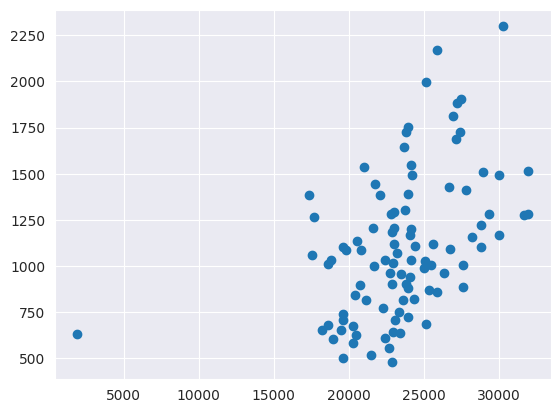

In [8]:
sns.set_style("darkgrid")

x_scatter = df_energy_m['resid']
y_scatter = df_energy_m['PML_MDA']

plt.scatter(x_scatter, y_scatter)

In [9]:
columns = ['FECHA', 'anio', 'mes', 'PML_MDA', 'LOAD_MW',	'resid']

df_energy_m = df_energy_m[columns]

In [10]:
df_energy_m.info()

print(df_energy_m.index)

<class 'pandas.core.frame.DataFrame'>
Index: 96 entries, 0 to 95
Data columns (total 6 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   FECHA    96 non-null     datetime64[ns]
 1   anio     96 non-null     int64         
 2   mes      96 non-null     int64         
 3   PML_MDA  96 non-null     float64       
 4   LOAD_MW  96 non-null     float64       
 5   resid    96 non-null     float64       
dtypes: datetime64[ns](1), float64(3), int64(2)
memory usage: 5.2 KB
Index([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35,
       36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53,
       54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71,
       72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89,
       90, 91, 92, 93, 94, 95],
      dtype='int64')


## Dataset precios de carbón
* INEGI - Indice de precios de carbón mineral
* Coal (API4) FOB Richards Bay (ARGUS-McCloskey)

In [11]:
#df_coal_m = pd.read_csv("/content/drive/MyDrive/Colab_Notebooks/PythonEconomia/Tesis/Datasets/Carbon/Coal (API4) FOB Richards Bay (ARGUS-McCloskey) Futures Historical Data_monthly.csv")
# df_coal_m = pd.read_excel("/content/drive/MyDrive/Colab_Notebooks/MaestriaEconomia/Tesis/Datasets/Carbon/IndiceCarbon_Inegi.xlsx")


# df_coal_m.head(10)




In [12]:
# print(df_coal_m.info())

# df_coal_m['fecha'] = pd.to_datetime(df_coal_m['fecha'])

# df_coal_m.head()

In [13]:
# df_coal_m = df_coal_m[['fecha', 'Price']]

# df_coal_m.head()

In [14]:
# print(df_coal_m.info())

## Dataset de precios de gas natural


In [15]:
# df_gas_m = pd.read_excel("/content/drive/MyDrive/Colab_Notebooks/MaestriaEconomia/Tesis/Datasets/GasNatural/Índice de Precios de Gas Natural.xlsx")
# df_gas_m.head(10)

# df_gas_m['fecha'] = pd.to_datetime(df_gas_m['fecha'])

# gas_columns = df_gas_m.columns.values.tolist()

# print(gas_columns)

# print(df_gas_m.info())

In [16]:
# df_gas_m = df_gas_m[['fecha', 'Índice (MXN/GJ)', 'Índice (USD/MBtu)', 'Índice (USD/MWh)', 'Índice (MXN/MWh)', 'Indice (MXN/Mbtu)']]

# df_gas_m.head()

## Dataset de CO2

In [17]:
# df_co2_m = pd.read_excel("/content/drive/MyDrive/Colab_Notebooks/MaestriaEconomia/Tesis/Datasets/CO2/Datos históricos Futuros emisiones de carbono_CFI2Z3.xlsx")
# df_co2_m.head(10)

# df_co2_m['fecha'] = pd.to_datetime(df_co2_m['fecha'])

# co2_columns = df_co2_m.columns.values.tolist()

# print(co2_columns)

# print(df_co2_m.info())

In [18]:
# df_co2_m = df_co2_m[['fecha', 'Precio']]



# df_co2_m.head()

## Merge de datasets

In [19]:
# df_coal_co2 = pd.merge(df_coal_m, df_co2_m, how="left", on='fecha')

# rename_dict = {'Price': 'CoalPrice', 'Precio': 'CO2Price'}

# df_coal_co2.rename(columns = rename_dict, inplace = True)

# df_coal_co2.head()

In [20]:
# df_coal_co2.info()

## Dataset de energéticos

* Frecuencia mensual

In [21]:
df_energeticos = pd.read_excel('/content/drive/MyDrive/Colab_Notebooks/MaestriaEconomia/Tesis/Datasets/INP_Energeticos.xlsx')

df_energeticos.head()

,periodo,anio,mes,HH_natgas_pi,gas_natural_pi,gas_natural_price,carbon_pi,carbon_price,diesel_price,diesel_pi,combustoleo_pi
0,2015-01-01,2015,1,82.244072,82.244072,2.993684,35.424660,59.780000,1.531190,47.629147,83.549462
1,2015-02-01,2015,2,78.976287,78.976287,2.874737,36.347220,61.336842,1.827500,56.846139,80.905780
2,2015-03-01,2015,3,77.772228,77.772228,2.830909,36.431784,61.479545,1.711091,53.225122,86.968016
3,2015-04-01,2015,4,71.677132,71.677132,2.609048,35.082309,59.202273,1.768545,55.012301,83.822946
4,2015-05-01,2015,5,78.296703,78.296703,2.850000,35.122443,59.270000,1.916571,59.616791,91.389346


In [22]:
# Revisión de valores nulos
total = df_energeticos.isnull().sum().sort_values(ascending=True)
percent = (df_energeticos.isnull().sum() / df_energeticos.isnull().count() * 100)
df_null = pd.concat([total, percent], keys=['total', 'percent'], axis=1).T


df_null

,periodo,anio,mes,HH_natgas_pi,gas_natural_pi,gas_natural_price,carbon_pi,carbon_price,diesel_price,diesel_pi,combustoleo_pi
total,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
percent,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [23]:
# Revisión de valores nulos
total = df_energeticos.isnull().sum().sort_values(ascending=True)
percent = (df_energeticos.isnull().sum() / df_energeticos.isnull().count() * 100)
df_null = pd.concat([total, percent], keys=['total', 'percent'], axis=1).T


df_null

,periodo,anio,mes,HH_natgas_pi,gas_natural_pi,gas_natural_price,carbon_pi,carbon_price,diesel_price,diesel_pi,combustoleo_pi
total,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
percent,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [24]:
# df_energetics = pd.merge(df_coal_co2, df_gas_m, how='left', on='fecha' )


# df_energetics.head()

# print(df_energetics.info())

# df_energetics.tail()

df_energy_m.head()


,FECHA,anio,mes,PML_MDA,LOAD_MW,resid
0,2016-01-01,2016,1,631.41,2450.05,1924.66
1,2016-02-01,2016,2,653.78,23571.34,18248.17
2,2016-03-01,2016,3,628.65,25917.16,20456.45
3,2016-04-01,2016,4,710.64,26733.16,19619.01
4,2016-05-01,2016,5,962.57,29547.37,22727.65


In [25]:
df_rwc = pd.merge(df_energy_m, df_energeticos, how='left', on=['anio', 'mes'])


df_rwc.head()


,FECHA,anio,mes,PML_MDA,LOAD_MW,resid,periodo,HH_natgas_pi,gas_natural_pi,gas_natural_price,carbon_pi,carbon_price,diesel_price,diesel_pi,combustoleo_pi
0,2016-01-01,2016,1,631.41,2450.05,1924.66,2016-01-01,62.702773,62.702773,2.282381,27.470938,46.357895,0.957857,29.795064,38.880355
1,2016-02-01,2016,2,653.78,23571.34,18248.17,2016-02-01,54.644165,54.644165,1.989048,26.129983,44.095000,0.998905,31.071890,37.467353
2,2016-03-01,2016,3,628.65,25917.16,20456.45,2016-03-01,47.479694,47.479694,1.728261,27.179395,45.865909,1.127391,35.068587,41.615198
3,2016-04-01,2016,4,710.64,26733.16,19619.01,2016-04-01,52.708006,52.708006,1.918571,26.838403,45.290476,1.198714,37.287156,47.267208
4,2016-05-01,2016,5,962.57,29547.37,22727.65,2016-05-01,52.809690,52.809690,1.922273,28.559718,48.195238,1.378136,42.868252,56.018706


In [26]:
print(df_rwc.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96 entries, 0 to 95
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   FECHA              96 non-null     datetime64[ns]
 1   anio               96 non-null     int64         
 2   mes                96 non-null     int64         
 3   PML_MDA            96 non-null     float64       
 4   LOAD_MW            96 non-null     float64       
 5   resid              96 non-null     float64       
 6   periodo            96 non-null     datetime64[ns]
 7   HH_natgas_pi       96 non-null     float64       
 8   gas_natural_pi     96 non-null     float64       
 9   gas_natural_price  96 non-null     float64       
 10  carbon_pi          96 non-null     float64       
 11  carbon_price       96 non-null     float64       
 12  diesel_price       96 non-null     float64       
 13  diesel_pi          96 non-null     float64       
 14  combustoleo_

In [27]:
df_rwc['resid_2'] = df_rwc['resid'] ** 2

In [28]:
df_rwc.to_excel("/content/drive/MyDrive/Colab_Notebooks/MaestriaEconomia/Tesis/Datasets/df_rwc.xlsx")


# Análisis Exploratorio de Datos

In [29]:
# Revisión de valores nulos
total = df_rwc.isnull().sum().sort_values(ascending=True)
percent = (df_rwc.isnull().sum() / df_rwc.isnull().count() * 100)
df_null = pd.concat([total, percent], keys=['total', 'percent'], axis=1).T


df_null

,FECHA,anio,mes,PML_MDA,LOAD_MW,resid,periodo,HH_natgas_pi,gas_natural_pi,gas_natural_price,carbon_pi,carbon_price,diesel_price,diesel_pi,combustoleo_pi,resid_2
total,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
percent,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [30]:
print(df_rwc.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96 entries, 0 to 95
Data columns (total 16 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   FECHA              96 non-null     datetime64[ns]
 1   anio               96 non-null     int64         
 2   mes                96 non-null     int64         
 3   PML_MDA            96 non-null     float64       
 4   LOAD_MW            96 non-null     float64       
 5   resid              96 non-null     float64       
 6   periodo            96 non-null     datetime64[ns]
 7   HH_natgas_pi       96 non-null     float64       
 8   gas_natural_pi     96 non-null     float64       
 9   gas_natural_price  96 non-null     float64       
 10  carbon_pi          96 non-null     float64       
 11  carbon_price       96 non-null     float64       
 12  diesel_price       96 non-null     float64       
 13  diesel_pi          96 non-null     float64       
 14  combustoleo_

## Gráficas

In [31]:
df_rwc_17_23 = df_rwc.loc[(df_rwc['FECHA'] >= '2017-01-01') & (df_rwc['FECHA'] < '2024-01-01') ]
df_rwc_17_23['Fecha'] = pd.to_datetime(df_rwc_17_23['FECHA'])
df_rwc_17_23.set_index('FECHA', inplace = True)


df_rwc_19_23 = df_rwc.loc[(df_rwc['FECHA'] >= '2019-01-01') & (df_rwc['FECHA'] < '2024-01-01') ]
df_rwc_19_23['Fecha'] = pd.to_datetime(df_rwc_19_23['FECHA'])
df_rwc_19_23.set_index('FECHA', inplace = True)


df_rwc_20_23 = df_rwc.loc[(df_rwc['FECHA'] >= '2020-01-01') & (df_rwc['FECHA'] < '2024-01-01') ]
df_rwc_20_23['Fecha'] = pd.to_datetime(df_rwc_20_23['FECHA'])
df_rwc_20_23.set_index('FECHA', inplace = True)

print(df_rwc_20_23.info())

df_rwc_20_23.head()




<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 48 entries, 2020-01-01 to 2023-12-01
Data columns (total 16 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   anio               48 non-null     int64         
 1   mes                48 non-null     int64         
 2   PML_MDA            48 non-null     float64       
 3   LOAD_MW            48 non-null     float64       
 4   resid              48 non-null     float64       
 5   periodo            48 non-null     datetime64[ns]
 6   HH_natgas_pi       48 non-null     float64       
 7   gas_natural_pi     48 non-null     float64       
 8   gas_natural_price  48 non-null     float64       
 9   carbon_pi          48 non-null     float64       
 10  carbon_price       48 non-null     float64       
 11  diesel_price       48 non-null     float64       
 12  diesel_pi          48 non-null     float64       
 13  combustoleo_pi     48 non-null     float64     

<ipython-input-31-d6f1d6092305>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_rwc_17_23['Fecha'] = pd.to_datetime(df_rwc_17_23['FECHA'])
<ipython-input-31-d6f1d6092305>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_rwc_19_23['Fecha'] = pd.to_datetime(df_rwc_19_23['FECHA'])
<ipython-input-31-d6f1d6092305>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: htt

,anio,mes,PML_MDA,LOAD_MW,resid,periodo,HH_natgas_pi,gas_natural_pi,gas_natural_price,carbon_pi,carbon_price,diesel_price,diesel_pi,combustoleo_pi,resid_2,Fecha
FECHA,,,,,,,,,,,,,,,,
2020-01-01,2020,1,478.13,28496.76,22879.84,2020-01-01,55.455259,54.919162,2.018571,30.481383,51.438095,1.777391,55.287460,71.744055,5.234871e+08,2020-01-01
2020-02-01,2020,2,516.63,27020.94,21462.14,2020-02-01,52.559283,50.915120,1.913158,28.816727,48.628947,1.555350,48.380652,92.164218,4.606235e+08,2020-02-01
2020-03-01,2020,3,554.82,29530.52,22681.25,2020-03-01,49.145299,48.755802,1.788889,28.212633,47.609524,1.124318,34.972994,77.122580,5.144391e+08,2020-03-01
2020-04-01,2020,4,500.02,26580.57,19633.51,2020-04-01,47.776033,51.666901,1.739048,28.324095,47.797619,0.808136,25.137856,42.709136,3.854747e+08,2020-04-01
2020-05-01,2020,5,581.56,28247.42,20295.53,2020-05-01,48.035714,56.013189,1.748500,27.168486,45.847500,0.841476,26.174923,31.541859,4.119085e+08,2020-05-01


### Precios

Text(0.5, 0, 'Periodo')

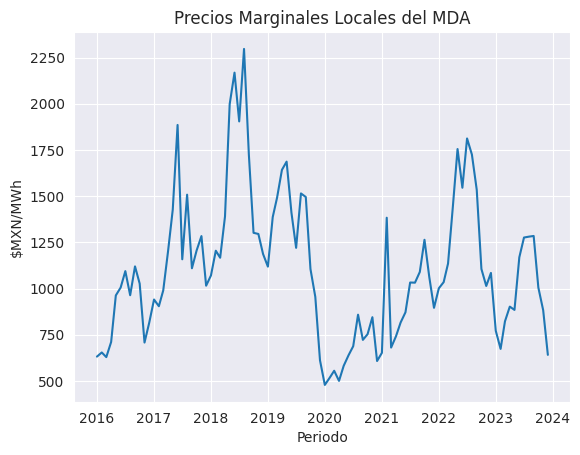

In [32]:
ax = sns.lineplot(data = df_rwc, x='FECHA', y='PML_MDA').set_title('Precios Marginales Locales del MDA')
plt.ylabel('$MXN/MWh')
plt.xlabel('Periodo')


Text(0.5, 1.0, 'PML del MDA ($MXN/MWh)')

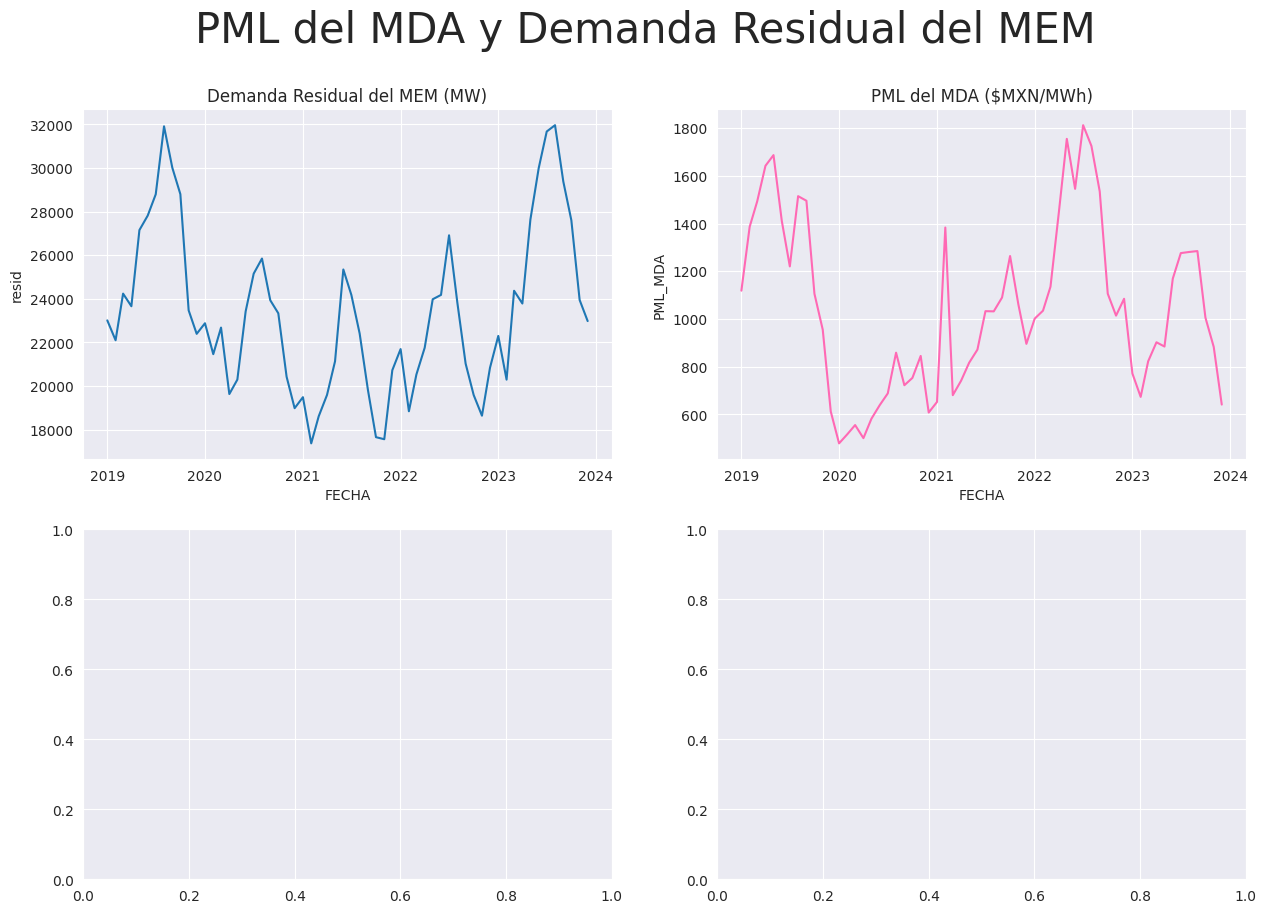

In [33]:
fig, axs = plt.subplots(2,2, figsize=(15, 10))
fig.suptitle('PML del MDA y Demanda Residual del MEM', fontsize=30)


sns.lineplot(data = df_rwc_19_23, x='FECHA', y='resid', ax= axs[0,0]).set_title('Demanda Residual del MEM (MW)')
sns.lineplot(data = df_rwc_19_23, x='FECHA', y='PML_MDA', ax=axs[0,1], color='hotpink').set_title('PML del MDA ($MXN/MWh)')


Text(0.5, 1.0, 'índice de precios del Combustóleo')

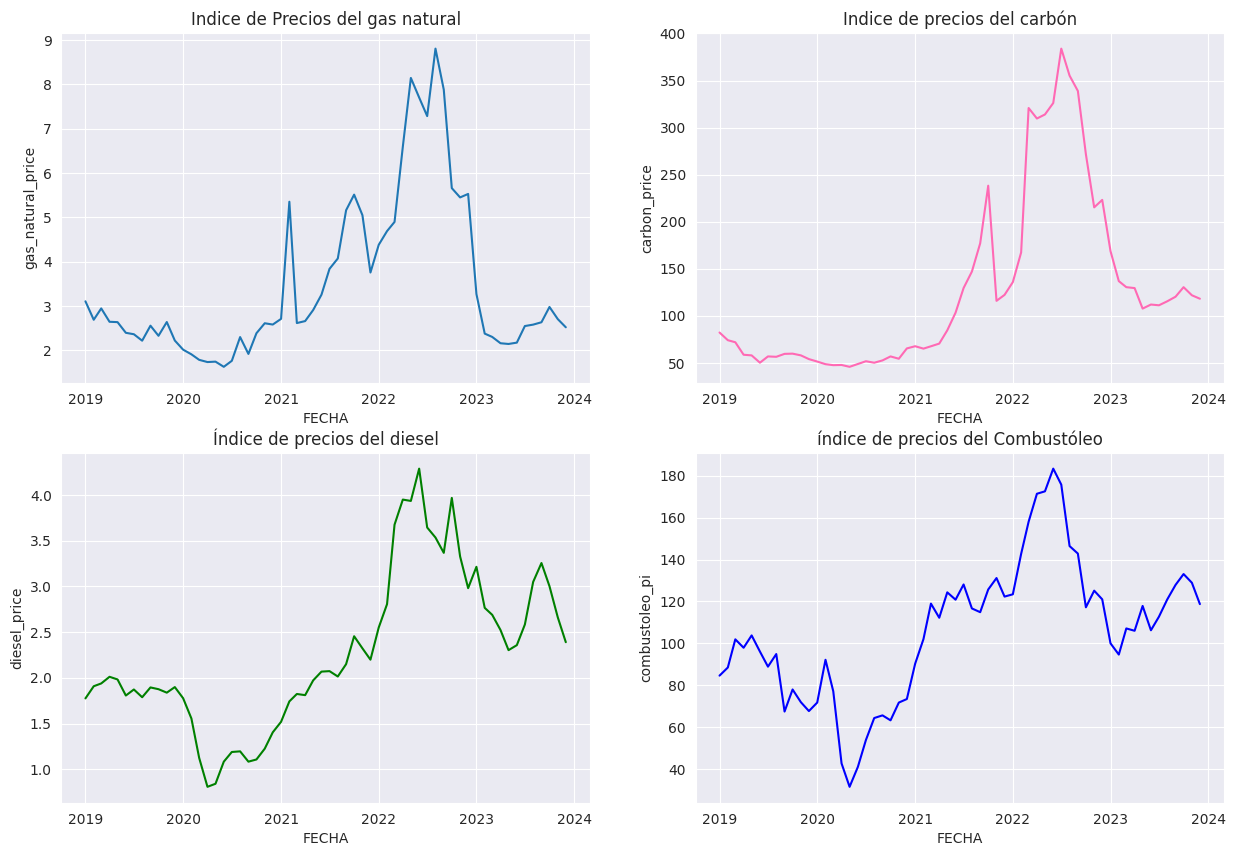

In [34]:
sns.set_style("darkgrid")

fig, axs = plt.subplots(2,2, figsize=(15, 10))
#fig.suptitle('Indice de Precios de los Energéticos', fontsize=30)


sns.lineplot(data = df_rwc_19_23, x='FECHA', y='gas_natural_price', ax= axs[0,0]).set_title('Indice de Precios del gas natural')
sns.lineplot(data = df_rwc_19_23, x='FECHA', y='carbon_price', ax=axs[0,1], color='hotpink').set_title('Indice de precios del carbón')
sns.lineplot(data = df_rwc_19_23, x='FECHA', y='diesel_price', ax=axs[1,0], color= 'green').set_title('Índice de precios del diesel')
sns.lineplot(data = df_rwc_19_23, x='FECHA', y='combustoleo_pi', ax=axs[1,1], color = 'blue').set_title('índice de precios del Combustóleo')


### Demanda Residual

Text(0, 0.5, 'PML del MDA ($MXN/MWh)')

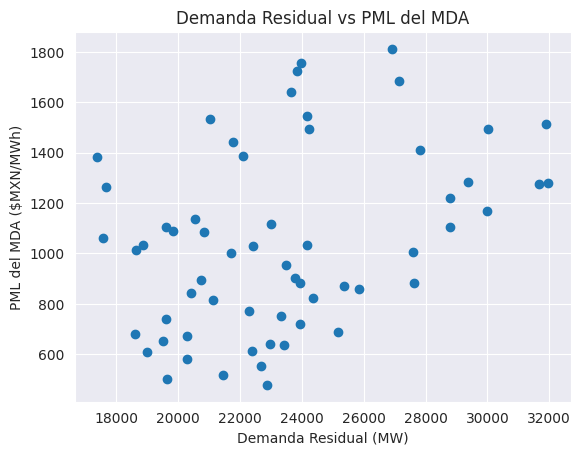

In [35]:
# resid = df_rwc_20_23['resid']
# pml = df_rwc_20_23['PML_MDA']

# px.scatter(df_rwc_20_23,x='resid', y= 'PML_MDA' )

plt.scatter(df_rwc_19_23['resid'], df_rwc_19_23['PML_MDA'])
plt.title('Demanda Residual vs PML del MDA')
plt.xlabel('Demanda Residual (MW)')
plt.ylabel('PML del MDA ($MXN/MWh)')


In [36]:
df_rwc_19_23.head()

energetics_1 = df_rwc_19_23[['gas_natural_pi', 'carbon_pi', 'combustoleo_pi', 'PML_MDA']]
energetics_2 = df_rwc_19_23[['gas_natural_pi', 'carbon_pi', 'combustoleo_pi', 'PML_MDA']]
descriptive_stats = df_rwc_19_23[['gas_natural_pi', 'carbon_pi', 'combustoleo_pi', 'PML_MDA', 'resid']]


In [37]:
descriptive_stats.describe()

,gas_natural_pi,carbon_pi,combustoleo_pi,PML_MDA,resid
count,60.000000,60.000000,60.000000,60.000000,60.000000
mean,82.984391,75.211146,105.863777,1044.672500,23383.707167
std,55.846486,54.736124,33.310538,357.312537,3751.924664
min,17.171924,27.168486,31.541859,478.130000,17371.550000
25%,55.337046,34.197136,82.945517,749.600000,20503.082500
50%,64.965275,62.539814,106.682590,1022.695000,22995.115000
75%,97.821621,82.616178,124.543965,1281.572500,25201.742500
max,432.595266,227.488482,183.381725,1812.260000,31961.560000


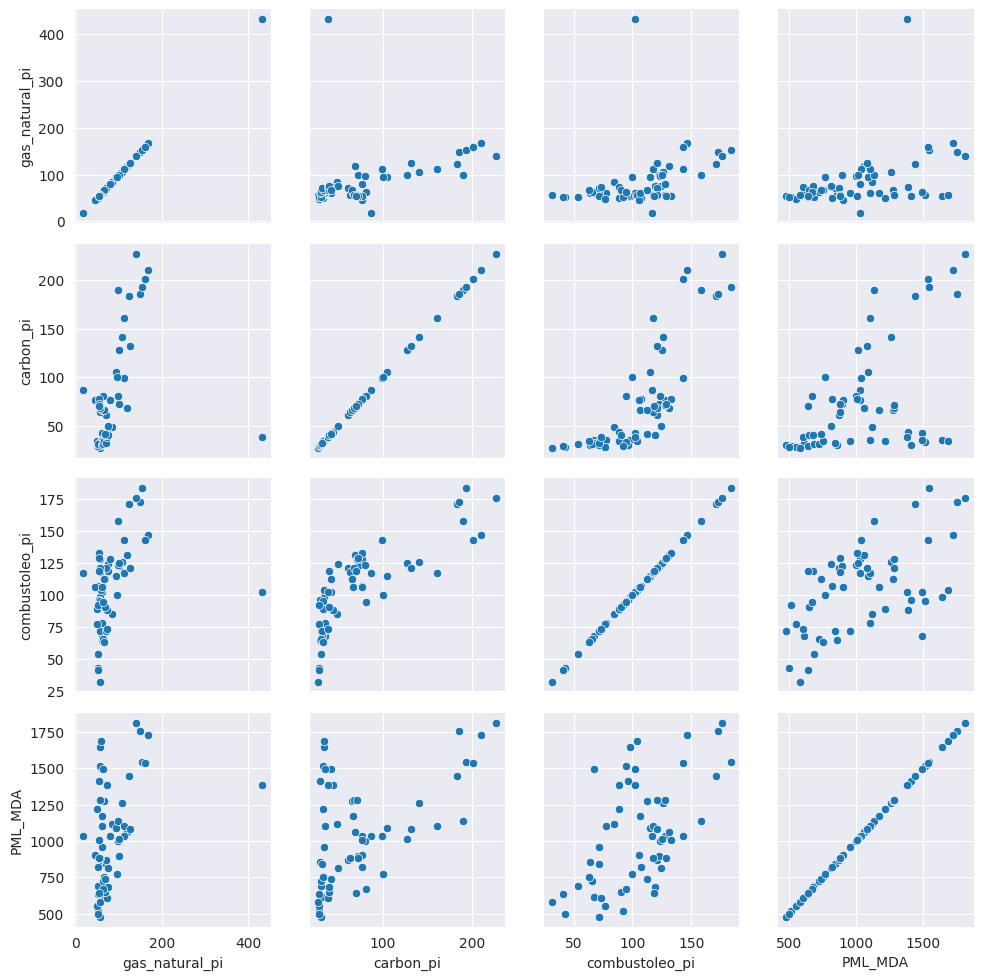

In [38]:
g = sns.PairGrid(energetics_1)
g.map(sns.scatterplot)

In [39]:
# Revisión de valores nulos
total = df_rwc.isnull().sum().sort_values(ascending=True)

percent = (df_rwc.isnull().sum() / df_rwc.isnull().count() * 100)

df_null = pd.concat([total, percent], keys=['total', 'percent'], axis=1).T


df_null

,FECHA,anio,mes,PML_MDA,LOAD_MW,resid,periodo,HH_natgas_pi,gas_natural_pi,gas_natural_price,carbon_pi,carbon_price,diesel_price,diesel_pi,combustoleo_pi,resid_2
total,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
percent,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [40]:
df_rwc['fecha'] = pd.to_datetime(df_rwc['FECHA'], format= '%Y-%m-%d')

print(df_rwc.info())
df_rwc.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96 entries, 0 to 95
Data columns (total 17 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   FECHA              96 non-null     datetime64[ns]
 1   anio               96 non-null     int64         
 2   mes                96 non-null     int64         
 3   PML_MDA            96 non-null     float64       
 4   LOAD_MW            96 non-null     float64       
 5   resid              96 non-null     float64       
 6   periodo            96 non-null     datetime64[ns]
 7   HH_natgas_pi       96 non-null     float64       
 8   gas_natural_pi     96 non-null     float64       
 9   gas_natural_price  96 non-null     float64       
 10  carbon_pi          96 non-null     float64       
 11  carbon_price       96 non-null     float64       
 12  diesel_price       96 non-null     float64       
 13  diesel_pi          96 non-null     float64       
 14  combustoleo_

,FECHA,anio,mes,PML_MDA,LOAD_MW,resid,periodo,HH_natgas_pi,gas_natural_pi,gas_natural_price,carbon_pi,carbon_price,diesel_price,diesel_pi,combustoleo_pi,resid_2,fecha
0,2016-01-01,2016,1,631.41,2450.05,1924.66,2016-01-01,62.702773,62.702773,2.282381,27.470938,46.357895,0.957857,29.795064,38.880355,3.704316e+06,2016-01-01
1,2016-02-01,2016,2,653.78,23571.34,18248.17,2016-02-01,54.644165,54.644165,1.989048,26.129983,44.095000,0.998905,31.071890,37.467353,3.329957e+08,2016-02-01
2,2016-03-01,2016,3,628.65,25917.16,20456.45,2016-03-01,47.479694,47.479694,1.728261,27.179395,45.865909,1.127391,35.068587,41.615198,4.184663e+08,2016-03-01
3,2016-04-01,2016,4,710.64,26733.16,19619.01,2016-04-01,52.708006,52.708006,1.918571,26.838403,45.290476,1.198714,37.287156,47.267208,3.849056e+08,2016-04-01
4,2016-05-01,2016,5,962.57,29547.37,22727.65,2016-05-01,52.809690,52.809690,1.922273,28.559718,48.195238,1.378136,42.868252,56.018706,5.165461e+08,2016-05-01


### Variables originales

* Demanda Residual
* PML del MDA
* Indice de precios del gas natural
* Indice de precios del carbón
* Indice de precios del Combustóleo

Text(0.5, 0, 'Periodo')

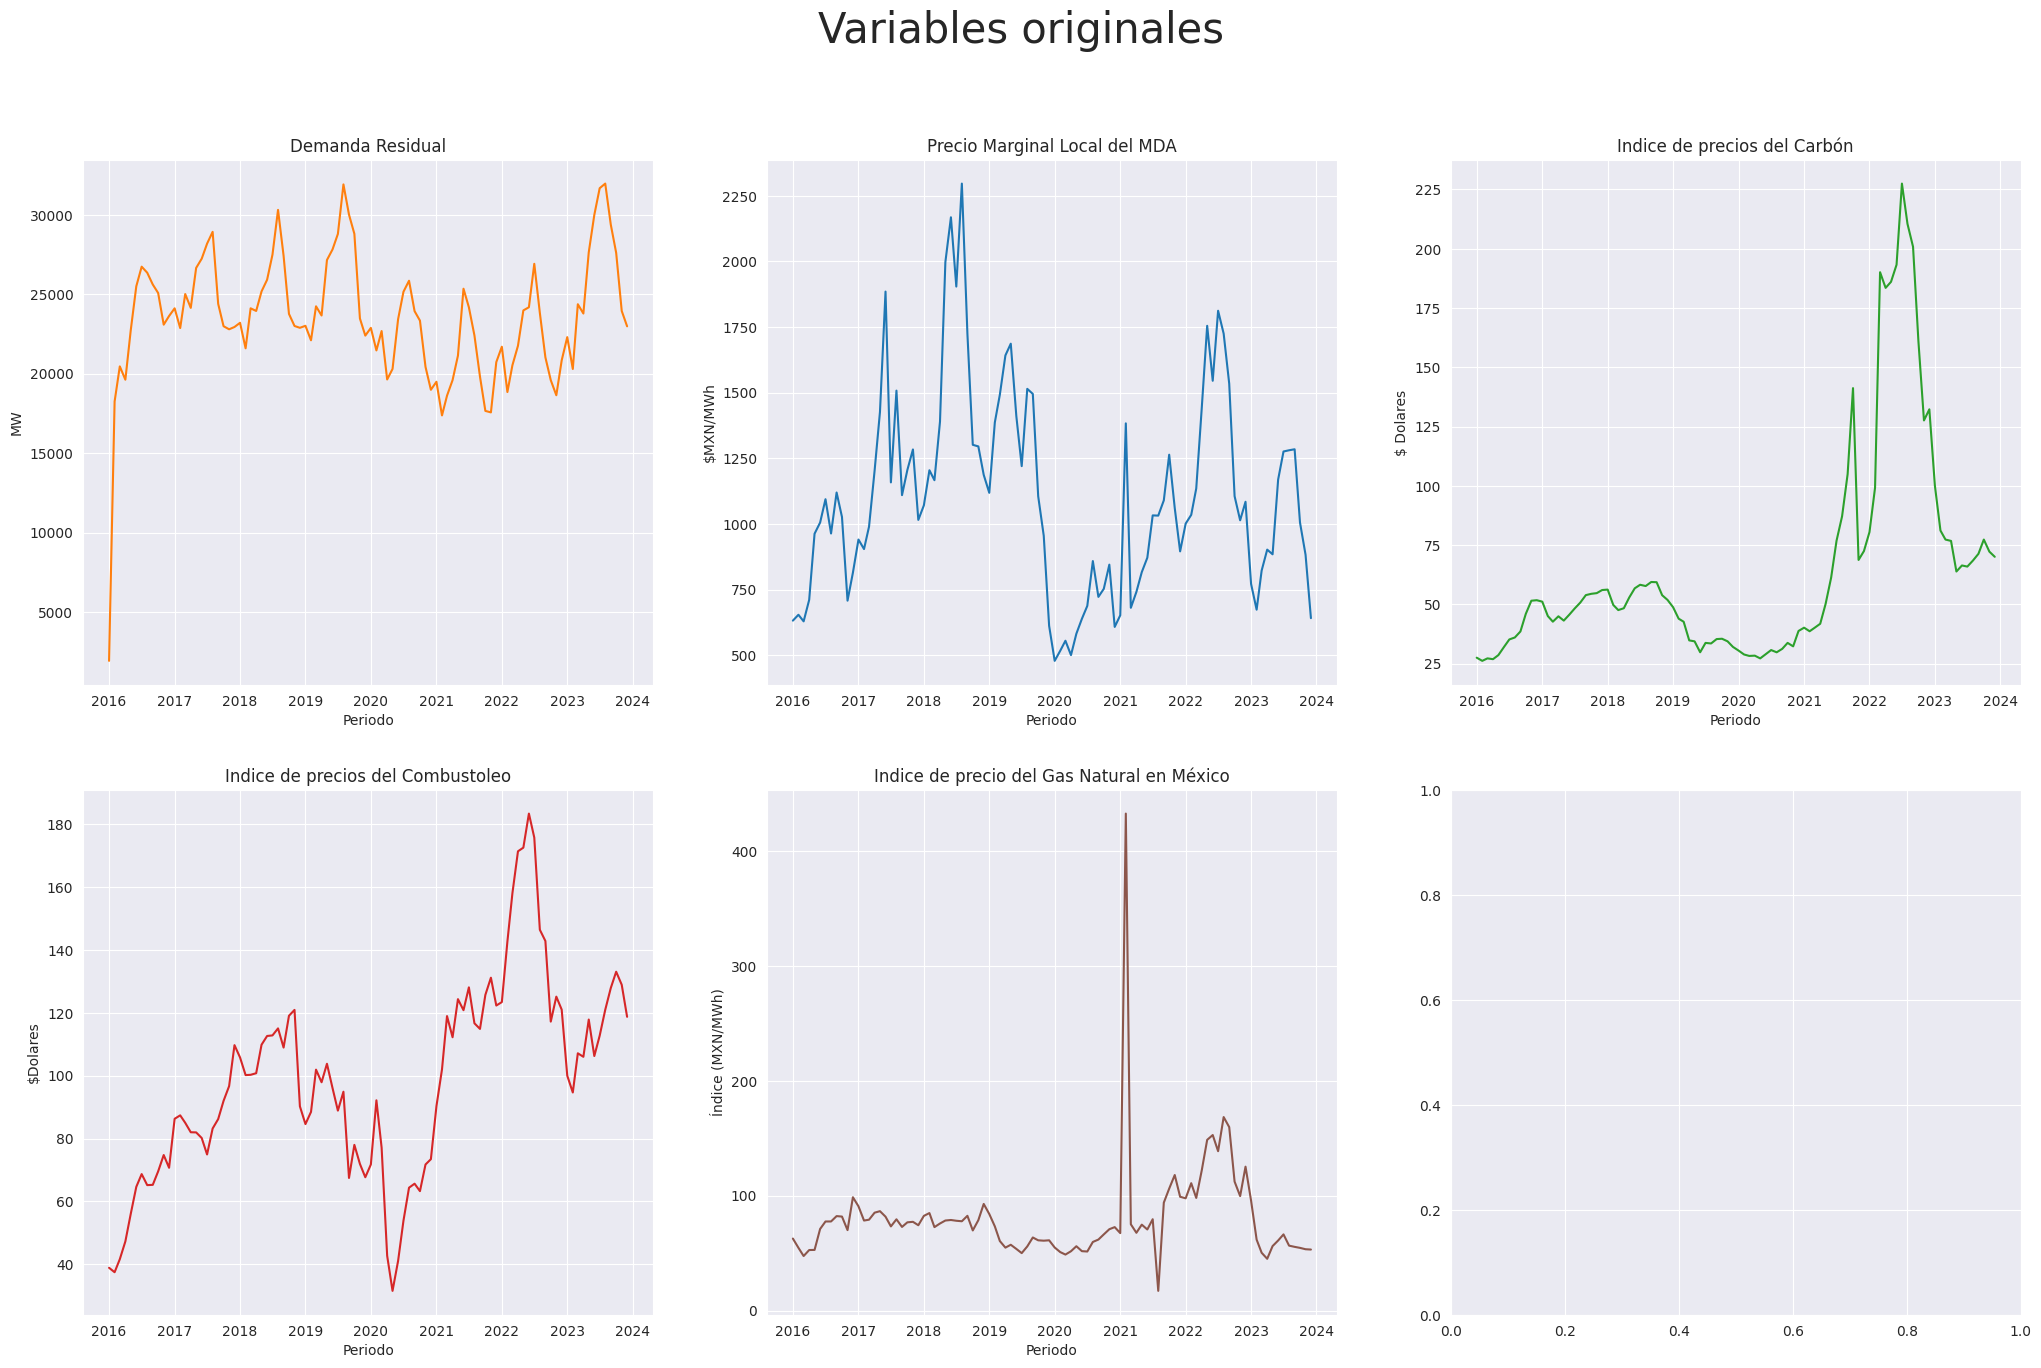

In [41]:
y_resid = df_rwc['resid']
x_pml_mda = df_rwc['PML_MDA']

x_coalprice = df_rwc['carbon_pi']
x_combustoleop = df_rwc['combustoleo_pi']
x_gas_index = df_rwc['gas_natural_pi']
x_diesel_pi = df_rwc['diesel_pi']

x = df_rwc['fecha']

sns.set_style("darkgrid")

fig, axs = plt.subplots(2,3, figsize=(25, 15))
fig.suptitle('Variables originales', fontsize=30)

axs[0,0].plot(x, y_resid, 'tab:orange')
axs[0,0].set_title('Demanda Residual')
axs[0,0].set_ylabel('MW')
axs[0,0].set_xlabel('Periodo')

axs[0,1].plot(x, x_pml_mda, 'tab:blue')
axs[0,1].set_title('Precio Marginal Local del MDA')
axs[0,1].set_ylabel('$MXN/MWh')
axs[0,1].set_xlabel('Periodo')


axs[0,2].plot(x, x_coalprice, 'tab:green')
axs[0,2].set_title('Indice de precios del Carbón')
axs[0,2].set_ylabel('$ Dolares')
axs[0,2].set_xlabel('Periodo')

axs[1,0].plot(x, x_combustoleop, 'tab:red')
axs[1,0].set_title('Indice de precios del Combustoleo')
axs[1,0].set_ylabel('$Dolares')
axs[1,0].set_xlabel('Periodo')

axs[1,1].plot(x, x_gas_index, 'tab:brown')
axs[1,1].set_title('Indice de precio del Gas Natural en México')
axs[1,1].set_ylabel('Índice (MXN/MWh)')
axs[1,1].set_xlabel('Periodo')



## Outlier correction

In [42]:
# # Tratamiento Outliers demanda residual
# truncate_resid_upper = 25000
# truncate_resid_lower = 20000
# mean_gas = df_rwc['resid'].mean()
# print(mean_gas)

# df_rwc.loc[df_rwc['resid'] > 28000, 'resid'] = pd.NA
# df_rwc.fillna(truncate_resid_upper, inplace=True)

# df_rwc.loc[df_rwc['resid'] < 20000, 'resid'] = pd.NA
# df_rwc.fillna(truncate_resid_lower, inplace=True)

In [43]:
#Tratamiento Outliers PMLs

# truncate_pml_upper = 1500
# truncate_pml_lower = 750
# mean_gas = df_rwc['PML_MDA'].mean()
# print(mean_gas)

# df_rwc.loc[df_rwc['PML_MDA'] > 1500, 'PML_MDA'] = pd.NA
# df_rwc.fillna(df_rwc['PML_MDA'].median(), inplace=True)

# df_rwc.loc[df_rwc['PML_MDA'] < 750, 'PML_MDA'] = pd.NA
# df_rwc.fillna(df_rwc['PML_MDA'].median(), inplace=True)

In [44]:
# Tratamiento Outliers gas natural

# truncate_gas_upper = 100
# truncate_gas_lower = 60
# mean_gas = df_rwc['gas_natural_pi'].mean()
# median_gas = df_rwc['gas_natural_pi'].median()
# print(mean_gas)

# df_rwc.loc[df_rwc['gas_natural_pi'] >= 100, 'gas_natural_pi'] = pd.NA
# df_rwc.fillna(median_gas, inplace = True)
# df_rwc.loc[df_rwc['gas_natural_pi'] < 60, 'gas_natural_pi'] = pd.NA
# df_rwc.fillna(median_gas, inplace=True)

In [45]:
#Combustoleo
# truncate_comb_upper = 110
# truncate_comb_lower = 70

# df_rwc.loc[df_rwc['combustoleo_pi'] > 120, 'combustoleo_pi'] = pd.NA
# df_rwc.fillna(df_rwc['combustoleo_pi'].median(), inplace=True)


# # df_rwc.loc[df_rwc['combustoleo_pi'] > 200, 'combustoleo_pi'] = pd.NA
# # df_rwc.fillna(df_rwc['combustoleo_pi'].mean(), inplace=True)

# df_rwc.loc[df_rwc['combustoleo_pi'] < 70, 'combustoleo_pi'] = pd.NA
# df_rwc.fillna(df_rwc['combustoleo_pi'].median(), inplace=True)

In [46]:
# Tratamiento outliers Carbón
# truncate_coal_upper = 75
# truncate_coal_lower = 40

# df_rwc.loc[df_rwc['carbon_pi'] > 75, 'carbon_pi'] = pd.NA
# df_rwc.fillna(df_rwc['carbon_pi'].median(), inplace=True)


## Data imputation

In [47]:
# df_energeticos['gas_natural_d'] = df_energeticos['gas_natural_pi'].diff(periods= 12)
# df_energeticos['carbon_d'] = df_energeticos['carbon_pi'].diff(periods= 12)
# df_energeticos['diesel_d'] = df_energeticos['diesel_pi'].diff(periods= 12)
# df_energeticos['combustoleo_d'] = df_energeticos['combustoleo_pi'].diff(periods= 12)

# df_energeticos['gas_natural_pct'] = df_energeticos['gas_natural_pi'].pct_change(periods= 12) * 100
# df_energeticos['carbon_pct'] = df_energeticos['carbon_pi'].pct_change(periods= 12) * 100
# df_energeticos['diesel_pct'] = df_energeticos['diesel_pi'].pct_change(periods= 12) * 100
# df_energeticos['combustoleo_pct'] = df_energeticos['combustoleo_pi'].pct_change(periods= 12) * 100



df_rwc['gas_natural_d'] = df_rwc['gas_natural_pi'].diff(periods= 12)
df_rwc['carbon_d'] = df_rwc['carbon_pi'].diff(periods= 12)
df_rwc['diesel_d'] = df_rwc['diesel_pi'].diff(periods= 12)
df_rwc['combustoleo_d'] = df_rwc['combustoleo_pi'].diff(periods= 12)

df_rwc['gas_natural_pct'] = df_rwc['gas_natural_pi'].pct_change(periods= 12) * 100
df_rwc['carbon_pct'] = df_rwc['carbon_pi'].pct_change(periods= 12) * 100
df_rwc['diesel_pct'] = df_rwc['diesel_pi'].pct_change(periods= 12) * 100
df_rwc['combustoleo_pct'] = df_rwc['combustoleo_pi'].pct_change(periods= 12) * 100

df_rwc.head()

,FECHA,anio,mes,PML_MDA,LOAD_MW,resid,periodo,HH_natgas_pi,gas_natural_pi,gas_natural_price,...,resid_2,fecha,gas_natural_d,carbon_d,diesel_d,combustoleo_d,gas_natural_pct,carbon_pct,diesel_pct,combustoleo_pct
0,2016-01-01,2016,1,631.41,2450.05,1924.66,2016-01-01,62.702773,62.702773,2.282381,...,3.704316e+06,2016-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2016-02-01,2016,2,653.78,23571.34,18248.17,2016-02-01,54.644165,54.644165,1.989048,...,3.329957e+08,2016-02-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2016-03-01,2016,3,628.65,25917.16,20456.45,2016-03-01,47.479694,47.479694,1.728261,...,4.184663e+08,2016-03-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2016-04-01,2016,4,710.64,26733.16,19619.01,2016-04-01,52.708006,52.708006,1.918571,...,3.849056e+08,2016-04-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2016-05-01,2016,5,962.57,29547.37,22727.65,2016-05-01,52.809690,52.809690,1.922273,...,5.165461e+08,2016-05-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [48]:
#Imputation
df_rwc['gas_natural_pi'] = df_rwc['gas_natural_pi'].fillna(df_rwc['gas_natural_pi'].median())
df_rwc['carbon_pi'] = df_rwc['carbon_pi'].fillna(df_rwc['carbon_pi'].median())
df_rwc['diesel_pi'] = df_rwc['diesel_pi'].fillna(df_rwc['diesel_pi'].median())
df_rwc['combustoleo_pi'] = df_rwc['combustoleo_pi'].fillna(df_rwc['combustoleo_pi'].median())

df_rwc['gas_natural_d'] = df_rwc['gas_natural_d'].fillna(df_rwc['gas_natural_d'].median())
df_rwc['carbon_d'] = df_rwc['carbon_d'].fillna(df_rwc['carbon_d'].median())
df_rwc['diesel_d'] = df_rwc['diesel_d'].fillna(df_rwc['diesel_d'].median())
df_rwc['combustoleo_d'] = df_rwc['combustoleo_d'].fillna(df_rwc['combustoleo_d'].median())

df_rwc['gas_natural_pct'] = df_rwc['gas_natural_pct'].fillna(df_rwc['gas_natural_pct'].median())
df_rwc['carbon_pct'] = df_rwc['carbon_pct'].fillna(df_rwc['carbon_pct'].median())
df_rwc['diesel_pct'] = df_rwc['diesel_pct'].fillna(df_rwc['diesel_pct'].median())
df_rwc['combustoleo_pct'] = df_rwc['combustoleo_pct'].fillna(df_rwc['combustoleo_pct'].median())

In [49]:
	#Imputation
# df_rwc['gas_natural_pi'] = df_rwc['gas_natural_pi'].fillna(df_rwc['gas_natural_pi'].median())
# df_rwc['carbon_pi'] = df_rwc['carbon_pi'].fillna(df_rwc['carbon_pi'].median())
# df_rwc['gasolina_pi'] = df_rwc['gasolina_pi'].fillna(df_rwc['gasolina_pi'].median())
# df_rwc['diesel'] = df_rwc['diesel'].fillna(df_rwc['diesel'].median())
# df_rwc['combustoleo'] = df_rwc['combustoleo'].fillna(df_rwc['combustoleo'].median())

# df_rwc['gas_natural_d'] = df_rwc['gas_natural_d'].fillna(df_rwc['gas_natural_d'].median())
# df_rwc['carbon_d'] = df_rwc['carbon_d'].fillna(df_rwc['carbon_d'].median())
# df_rwc['gasolina_d'] = df_rwc['gasolina_d'].fillna(df_rwc['gasolina_d'].median())
# df_rwc['diesel_d'] = df_rwc['diesel_d'].fillna(df_rwc['diesel_d'].median())
# df_rwc['combustoleo_d'] = df_rwc['combustoleo_d'].fillna(df_rwc['combustoleo_d'].median())

# df_rwc['gas_natural_pct'] = df_rwc['gas_natural_pct'].fillna(df_rwc['gas_natural_pct'].median())
# df_rwc['carbon_pct'] = df_rwc['carbon_pct'].fillna(df_rwc['carbon_pct'].median())
# df_rwc['gasolina_pct'] = df_rwc['gasolina_pct'].fillna(df_rwc['gasolina_pct'].median())
# df_rwc['diesel_pct'] = df_rwc['diesel_pct'].fillna(df_rwc['diesel_pct'].median())
# df_rwc['combustoleo_pct'] = df_rwc['combustoleo_pct'].fillna(df_rwc['combustoleo_pct'].median())


In [50]:
# Revisión de valores nulos
total = df_rwc.isnull().sum().sort_values(ascending=True)
percent = (df_rwc.isnull().sum() / df_rwc.isnull().count() * 100)
df_null = pd.concat([total, percent], keys=['total', 'percent'], axis=1).T


df_null

,FECHA,carbon_pct,gas_natural_pct,combustoleo_d,diesel_d,carbon_d,gas_natural_d,fecha,resid_2,combustoleo_pi,...,gas_natural_pi,HH_natgas_pi,periodo,resid,LOAD_MW,PML_MDA,mes,anio,carbon_price,combustoleo_pct
total,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
percent,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Deseasonalizing Data

In [51]:
# y_resid = df_rwc['RESID_DEMAND_MW']
# y_pml_mda = df_rwc['PML_MDA']

# y_coalprice = df_rwc['CoalPrice']
# y_co2price = df_rwc['CO2Price']
# y_gas_index = df_rwc['Índice (MXN/MWh)']

# resid_demand_seasonal = seasonal_decompose(y_resid, model = 'multiplicative', period = 12)
# y_resid_sa = y_resid / resid_demand_seasonal.seasonal

# pmlMDA_seasonal = seasonal_decompose(y_pml_mda, model = 'multiplicative', period = 12)
# y_pmlMDA_sa = y_pml_mda / pmlMDA_seasonal.seasonal

# print(y_resid_sa)
# print(y_pmlMDA_sa)





Text(0.5, 0, 'Periodo')

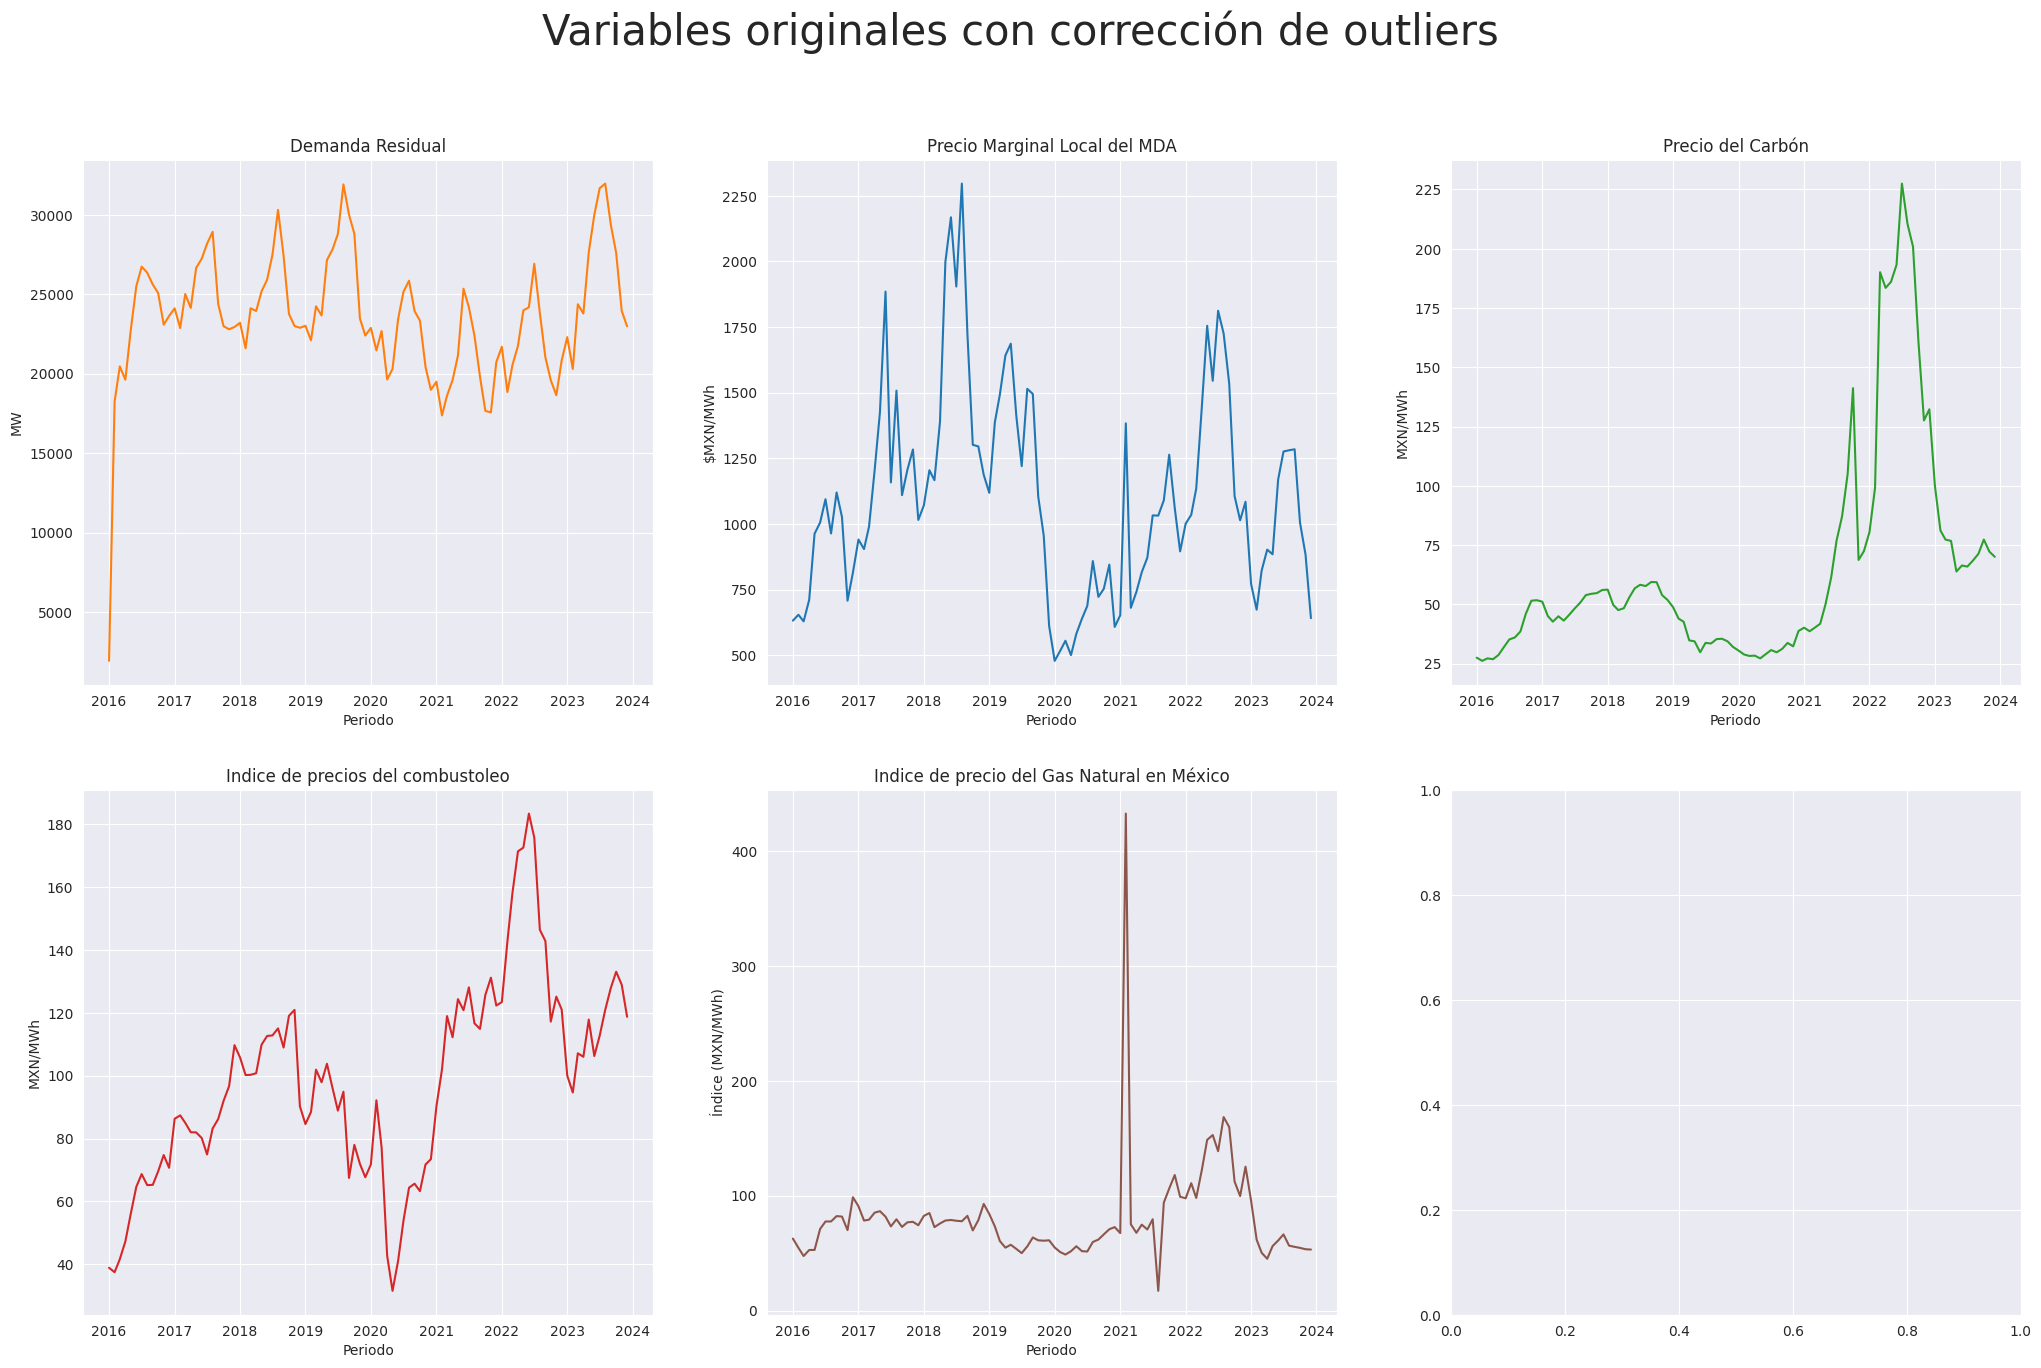

In [52]:
y_resid = df_rwc['resid']
x_pml_mda = df_rwc['PML_MDA']

x_coalprice = df_rwc['carbon_pi']
x_combustoleop = df_rwc['combustoleo_pi']
x_gas_index = df_rwc['gas_natural_pi']
x_diesel_pi = df_rwc['diesel_pi']

x = df_rwc['fecha']

sns.set_style("darkgrid")

fig, axs = plt.subplots(2,3, figsize=(25, 15))

fig.suptitle('Variables originales con corrección de outliers', fontsize=30)

axs[0,0].plot(x, y_resid, 'tab:orange')
axs[0,0].set_title('Demanda Residual')
axs[0,0].set_ylabel('MW')
axs[0,0].set_xlabel('Periodo')

axs[0,1].plot(x, x_pml_mda, 'tab:blue')
axs[0,1].set_title('Precio Marginal Local del MDA')
axs[0,1].set_ylabel('$MXN/MWh')
axs[0,1].set_xlabel('Periodo')


axs[0,2].plot(x, x_coalprice, 'tab:green')
axs[0,2].set_title('Precio del Carbón')
axs[0,2].set_ylabel('MXN/MWh')
axs[0,2].set_xlabel('Periodo')

axs[1,0].plot(x, x_combustoleop, 'tab:red')
axs[1,0].set_title('Indice de precios del combustoleo')
axs[1,0].set_ylabel('MXN/MWh')
axs[1,0].set_xlabel('Periodo')

axs[1,1].plot(x, x_gas_index, 'tab:brown')
axs[1,1].set_title('Indice de precio del Gas Natural en México')
axs[1,1].set_ylabel('Índice (MXN/MWh)')
axs[1,1].set_xlabel('Periodo')



In [53]:

# x = df_rwc['fecha']

# sns.set_style("darkgrid")

# fig, axs = plt.subplots(2,3, figsize=(25, 15))

# fig.suptitle('Variables desestacionalizadas con corrección de outliers', fontsize=30)

# axs[0,0].plot(x, y_resid_sa, 'tab:orange')
# axs[0,0].set_title('Demanda Residual')
# axs[0,0].set_ylabel('MW')
# axs[0,0].set_xlabel('Periodo')

# axs[0,1].plot(x, y_pmlMDA_sa, 'tab:blue')
# axs[0,1].set_title('Precio Marginal Local del MDA')
# axs[0,1].set_ylabel('$MXN/MWh')
# axs[0,1].set_xlabel('Periodo')


# axs[0,2].plot(x, y_coalprice, 'tab:green')
# axs[0,2].set_title('Precio del Carbón')
# axs[0,2].set_ylabel('$ Dolares')
# axs[0,2].set_xlabel('Periodo')

# axs[1,0].plot(x, y_co2price, 'tab:red')
# axs[1,0].set_title('Precio de los futuros de emisión de CO2')
# axs[1,0].set_ylabel('$Dolares')
# axs[1,0].set_xlabel('Periodo')

# axs[1,1].plot(x, y_gas_index, 'tab:brown')
# axs[1,1].set_title('Indice de precio del Gas Natural en México')
# axs[1,1].set_ylabel('Índice (MXN/MWh)')
# axs[1,1].set_xlabel('Periodo')


<ipython-input-54-747900a8195a>:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df_rwc['gas_natural_pi'])


<Axes: xlabel='gas_natural_pi', ylabel='Density'>

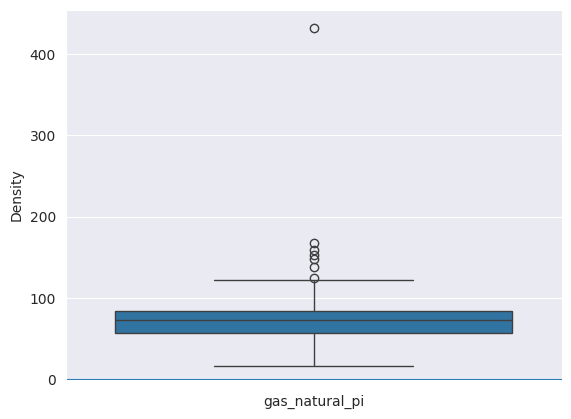

In [54]:
sns.distplot(df_rwc['gas_natural_pi'])

sns.boxplot(df_rwc['gas_natural_pi'])

## Pruebas de Estacionariedad

* ADF H0: Tiene raíz unitaria, no es estacionaria
* KPSS H0: Es estacionaria

* Se concluye que PMLs, demanda y indice de precios del gas son estacionarios a niveles

In [55]:
def adfuller_test(series, signif=0.05, name='', verbose=False):

    """Perform ADFuller to test for Stationarity of given series and print report"""
    r = adfuller(series, autolag='AIC')   # Constant (default)
    r_ct = adfuller(series, regression = 'ct', autolag='AIC')
    r_n = adfuller(series, regression = 'n', autolag='AIC')


    output_constant = {'test_statistic':round(r[0], 4), 'pvalue':round(r[1], 4), 'n_lags':round(r[2], 4), 'n_obs':r[3]}
    p_value_constant = output_constant['pvalue']

    output_ct = {'test_statistic':round(r_ct[0], 4), 'pvalue':round(r_ct[1], 4), 'n_lags':round(r_ct[2], 4), 'n_obs':r_ct[3]}
    p_value_ct = output_ct['pvalue']

    output_n = {'test_statistic':round(r_n[0], 4), 'pvalue':round(r_n[1], 4), 'n_lags':round(r_n[2], 4), 'n_obs':r_n[3]}
    p_value_n = output_n['pvalue']

    def adjust(val, length= 6):
       return str(val).ljust(length)

    # Print Summary for ADF constant
    print(f'    Augmented Dickey-Fuller Test on "{name}"', "\n   ", '-'*47)
    print('Regression Type: Constant (default)' )
    print(f' Null Hypothesis: Data has unit root. Non-Stationary.')
    print(f' Significance Level    = {signif}')
    print(f' Test Statistic        = {output_constant["test_statistic"]}')
    print(f' No. Lags Chosen       = {output_constant["n_lags"]}')

    for key,val in r[4].items():
        print(f' Critical value {adjust(key)} = {round(val, 3)}')

    if p_value_constant <= signif:
        print(f" => P-Value = {p_value_constant}. Rejecting Null Hypothesis.")
        print(f" => Series is Stationary.")
    else:
        print(f" => P-Value = {p_value_constant}. Weak evidence to reject the Null Hypothesis.")
        print(f" => Series is Non-Stationary.")


     # Print Summary for ADF constant and trend
    print('------------------------------------------------------------')
    print(f'    Augmented Dickey-Fuller Test on "{name}"', "\n   ", '-'*47)
    print('Regression Type: Constant and Trend' )
    print(f' Null Hypothesis: Data has unit root. Non-Stationary.')
    print(f' Significance Level    = {signif}')
    print(f' Test Statistic        = {output_ct["test_statistic"]}')
    print(f' No. Lags Chosen       = {output_ct["n_lags"]}')

    for key,val in r_ct[4].items():
        print(f' Critical value {adjust(key)} = {round(val, 3)}')

    if p_value_ct <= signif:
        print(f" => P-Value = {p_value_ct}. Rejecting Null Hypothesis.")
        print(f" => Series is Stationary.")
    else:
        print(f" => P-Value = {p_value_ct}. Weak evidence to reject the Null Hypothesis.")
        print(f" => Series is Non-Stationary.")



 # Print Summary for ADF Nothing
    print('------------------------------------------------------------')
    print(f'    Augmented Dickey-Fuller Test on "{name}"', "\n   ", '-'*47)
    print('Regression Type: Nothing' )
    print(f' Null Hypothesis: Data has unit root. Non-Stationary.')
    print(f' Significance Level    = {signif}')
    print(f' Test Statistic        = {output_n["test_statistic"]}')
    print(f' No. Lags Chosen       = {output_n["n_lags"]}')

    for key,val in r_n[4].items():
        print(f' Critical value {adjust(key)} = {round(val, 3)}')

    if p_value_n <= signif:
        print(f" => P-Value = {p_value_n}. Rejecting Null Hypothesis.")
        print(f" => Series is Stationary.")
    else:
        print(f" => P-Value = {p_value_n}. Weak evidence to reject the Null Hypothesis.")
        print(f" => Series is Non-Stationary.")

In [56]:
def kpss_test(timeseries, column):

    print('--------------------------------------------')
    print("Results of KPSS Test: ", column)
    print('KPSS type Rgresion: Constant')
    kpsstest = kpss(timeseries, regression="c", nlags="auto")

    kpss_output = pd.Series(
        kpsstest[0:3], index=["Test Statistic", "p-value", "Lags Used"]
    )
    for key, value in kpsstest[3].items():
        kpss_output["Critical Value (%s)" % key] = value

    print(kpss_output)


    print("Results of KPSS Test: ", column)
    print('KPSS type Rgresion: Constant and trend')

    kpss_ct = kpss(timeseries, regression="ct", nlags="auto")

    kpss_output = pd.Series(
        kpss_ct[0:3], index=["Test Statistic", "p-value", "Lags Used"]
    )
    for key, value in kpss_ct[3].items():
        kpss_output["Critical Value (%s)" % key] = value

    print(kpss_output)
    print('--------------------------------------------')


### Augmented Dickey Fuller

In [57]:
# ADF Test on each
columns = ['PML_MDA', 'HH_natgas_pi', 'gas_natural_pi', 'resid', 'carbon_pi', 'diesel_pi', 'combustoleo_pi']

df_adf = df_rwc[columns]

for name, column in df_adf.items():

    adfuller_test(column, name=column.name)
    print('\n')



    Augmented Dickey-Fuller Test on "PML_MDA" 
    -----------------------------------------------
Regression Type: Constant (default)
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -3.6304
 No. Lags Chosen       = 3
 Critical value 1%     = -3.504
 Critical value 5%     = -2.894
 Critical value 10%    = -2.584
 => P-Value = 0.0052. Rejecting Null Hypothesis.
 => Series is Stationary.
------------------------------------------------------------
    Augmented Dickey-Fuller Test on "PML_MDA" 
    -----------------------------------------------
Regression Type: Constant and Trend
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -3.7125
 No. Lags Chosen       = 3
 Critical value 1%     = -4.061
 Critical value 5%     = -3.459
 Critical value 10%    = -3.156
 => P-Value = 0.0215. Rejecting Null Hypothesis.
 => Series is Stationary.
---------------------------------------

### KPSS

In [58]:
for key, value in df_adf.items():
  kpss_test(df_adf[key], key)

--------------------------------------------
Results of KPSS Test:  PML_MDA
KPSS type Rgresion: Constant
Test Statistic           0.13739
p-value                  0.10000
Lags Used                5.00000
Critical Value (10%)     0.34700
Critical Value (5%)      0.46300
Critical Value (2.5%)    0.57400
Critical Value (1%)      0.73900
dtype: float64
Results of KPSS Test:  PML_MDA
KPSS type Rgresion: Constant and trend
Test Statistic           0.116663
p-value                  0.100000
Lags Used                5.000000
Critical Value (10%)     0.119000
Critical Value (5%)      0.146000
Critical Value (2.5%)    0.176000
Critical Value (1%)      0.216000
dtype: float64
--------------------------------------------
--------------------------------------------
Results of KPSS Test:  HH_natgas_pi
KPSS type Rgresion: Constant
Test Statistic           0.387196
p-value                  0.082674
Lags Used                5.000000
Critical Value (10%)     0.347000
Critical Value (5%)      0.463000
C

<ipython-input-56-11afcde140fb>:6: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpsstest = kpss(timeseries, regression="c", nlags="auto")
<ipython-input-56-11afcde140fb>:20: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_ct = kpss(timeseries, regression="ct", nlags="auto")
<ipython-input-56-11afcde140fb>:20: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_ct = kpss(timeseries, regression="ct", nlags="auto")
<ipython-input-56-11afcde140fb>:6: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpsstest

In [59]:
# # Calcular primera diferencias para precio del carbón y co2
# df_rwc['CoalPrice_diff'] = df_rwc['CoalPrice'].diff(periods = 1)
# mean_coal_diff = df_rwc['CoalPrice_diff'].mean()
# df_rwc.loc[0,['CoalPrice_diff']] = mean_coal_diff


# # Se aplica tasa de crecimiento de precios de carbon
# df_rwc['CoalPrice_l1'] = df_rwc['CoalPrice'].shift(1)
# median_col = df_rwc['CoalPrice'][0]
# df_rwc.loc[0,['CoalPrice_l1']] = median_col

# df_rwc['CoalPrice_tc'] = (np.log(df_rwc['CoalPrice']) - np.log(df_rwc['CoalPrice_l1'])) * 100


# df_rwc

# Estimacion

In [60]:
df_rwc_16_19 = df_rwc.loc[(df_rwc['fecha'] >= '2016-01-01') & (df_rwc['fecha'] < '2020-01-01') ]



df_rwc_16_21 = df_rwc.loc[(df_rwc['fecha'] >= '2016-01-01') & (df_rwc['fecha'] < '2022-01-01') ]

df_rwc_16_22 = df_rwc.loc[(df_rwc['fecha'] >= '2016-01-01') & (df_rwc['fecha'] < '2023-01-01') ]

df_rwc_19_23 = df_rwc.loc[(df_rwc['fecha'] >= '2019-01-01') & (df_rwc['fecha'] < '2024-01-01') ]

df_rwc_20_23 = df_rwc.loc[(df_rwc['fecha'] >= '2020-01-01') & (df_rwc['fecha'] < '2024-01-01') ]

df_rwc_17_23 = df_rwc.loc[(df_rwc['fecha'] >= '2017-01-01') & (df_rwc['fecha'] < '2024-01-01') ]

df_rwc_18_23 = df_rwc.loc[(df_rwc['fecha'] >= '2018-01-01') & (df_rwc['fecha'] < '2024-01-01') ]

In [61]:
df_rwc_16_19.head()

,FECHA,anio,mes,PML_MDA,LOAD_MW,resid,periodo,HH_natgas_pi,gas_natural_pi,gas_natural_price,...,resid_2,fecha,gas_natural_d,carbon_d,diesel_d,combustoleo_d,gas_natural_pct,carbon_pct,diesel_pct,combustoleo_pct
0,2016-01-01,2016,1,631.41,2450.05,1924.66,2016-01-01,62.702773,62.702773,2.282381,...,3.704316e+06,2016-01-01,-1.762554,4.997506,6.5643,14.038862,-2.194174,10.362699,13.083325,14.09721
1,2016-02-01,2016,2,653.78,23571.34,18248.17,2016-02-01,54.644165,54.644165,1.989048,...,3.329957e+08,2016-02-01,-1.762554,4.997506,6.5643,14.038862,-2.194174,10.362699,13.083325,14.09721
2,2016-03-01,2016,3,628.65,25917.16,20456.45,2016-03-01,47.479694,47.479694,1.728261,...,4.184663e+08,2016-03-01,-1.762554,4.997506,6.5643,14.038862,-2.194174,10.362699,13.083325,14.09721
3,2016-04-01,2016,4,710.64,26733.16,19619.01,2016-04-01,52.708006,52.708006,1.918571,...,3.849056e+08,2016-04-01,-1.762554,4.997506,6.5643,14.038862,-2.194174,10.362699,13.083325,14.09721
4,2016-05-01,2016,5,962.57,29547.37,22727.65,2016-05-01,52.809690,52.809690,1.922273,...,5.165461e+08,2016-05-01,-1.762554,4.997506,6.5643,14.038862,-2.194174,10.362699,13.083325,14.09721


In [62]:
y_resid = df_rwc['resid']

resid_2 = y_resid ** 2
resid_3 = y_resid ** 3

df_rwc['resid_2'] = resid_2
df_rwc['resid_2'] = resid_3

df_rwc_16_19['resid'] = y_resid
df_rwc_16_19['resid_2'] = y_resid ** 2
df_rwc_16_19['resid_3'] = y_resid ** 3

df_rwc_16_21['resid'] = y_resid
df_rwc_16_21['resid_2'] = y_resid ** 2
df_rwc_16_21['resid_3'] = y_resid ** 3


df_rwc_19_23['resid'] = y_resid
df_rwc_19_23['resid_2'] = y_resid ** 2
df_rwc_19_23['resid_3'] = y_resid ** 3

df_rwc_20_23['resid'] = y_resid
df_rwc_20_23['resid_2'] = y_resid ** 2
df_rwc_20_23['resid_3'] = y_resid ** 3

# df_rwc['pmlMDA_sa'] = y_pmlMDA_sa
# df_rwc['resid_sa'] = y_resid_sa
# df_rwc['resid_sa_2'] = y_resid_sa**2
# df_rwc['resid_sa_3'] = y_resid_sa**3
# resid_sa_2 = y_resid_sa ** 2
# resid_sa_3 = y_resid_sa ** 3


x_features = ['resid', 'gas_natural_pi', 'carbon_pct', 'combustoleo_pct']
x_features_1 = ['resid','resid_2', 'resid_3', 'gas_natural_d', 'carbon_d', 'combustoleo_d']
x_features_2 = ['resid','resid_2', 'resid_3', 'gas_natural_pct', 'carbon_pct', 'combustoleo_pct']


x_16_19 = ['resid','resid_2', 'resid_3', 'gas_natural_pi', 'carbon_pct', 'combustoleo_pct']
x_16_21 = ['resid','resid_2', 'resid_3', 'gas_natural_pi', 'carbon_pct', 'combustoleo_pct']
x_19_23 = ['resid', 'gas_natural_pct', 'carbon_pct', 'combustoleo_pct']

#x_20_23 = ['resid', 'gas_natural_pct', 'carbon_pct', 'combustoleo_pct']
x_20_23 = ['resid', 'gas_natural_d', 'carbon_d', 'combustoleo_d']

#x_17_23 = ['resid', 'gas_natural_d', 'carbon_d', 'combustoleo_d']
x_17_23 = ['resid', 'gas_natural_pct', 'carbon_pct', 'combustoleo_pct']



y = df_rwc['PML_MDA']
y_16_19 = df_rwc_16_19['PML_MDA']
y_16_21 = df_rwc_16_21['PML_MDA']
y_19_23 = df_rwc_19_23['PML_MDA']
y_20_23 = df_rwc_20_23['PML_MDA']
y_17_23 = df_rwc_17_23['PML_MDA']


X = df_rwc[x_features]
X_16_19 = df_rwc_16_19[x_16_19]
X_16_21 = df_rwc_16_21[x_16_21]
X_19_23 = df_rwc_19_23[x_19_23]
X_20_23 = df_rwc_20_23[x_20_23]
X_17_23 = df_rwc_17_23[x_17_23]


X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.1)
X_train_16_19, X_test_16_19, y_train_16_19, y_test_16_19 = train_test_split(X_16_19, y_16_19, random_state=42, test_size=0.1)
X_train_16_21, X_test_16_21, y_train_16_21, y_test_16_21 = train_test_split(X_16_21, y_16_21, random_state=42, test_size=0.1)
X_train_19_23, X_test_19_23, y_train_19_23, y_test_19_23 = train_test_split(X_19_23, y_19_23, random_state=42, test_size=0.1)
X_train_20_23, X_test_20_23, y_train_20_23, y_test_20_23 = train_test_split(X_20_23, y_20_23, random_state=42, test_size=0.1)

X_train_17_23, X_test_17_23, y_train_17_23, y_test_17_23 = train_test_split(X_17_23, y_17_23, random_state=42, test_size=0.1)


<ipython-input-62-12f06f849484>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_rwc_16_19['resid'] = y_resid
<ipython-input-62-12f06f849484>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_rwc_16_19['resid_2'] = y_resid ** 2
<ipython-input-62-12f06f849484>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide

## Regresion histórica

In [63]:
features = ['resid', 'diesel_d', 'combustoleo_d', 'gas_natural_d']

X_train, X_test, y_train, y_test = train_test_split(df_rwc[features], df_rwc['PML_MDA'], random_state=42, test_size=0.1)

In [64]:
# Build - fit model
X_train = sm.add_constant(X_train)
#print(X_train)

model = sm.OLS(y_train, X_train)
results = model.fit()

print(results.params)
print(results.summary())

const           -1025.210094
resid               0.087804
diesel_d            8.262549
combustoleo_d      -1.113536
gas_natural_d       2.016136
dtype: float64
                            OLS Regression Results                            
Dep. Variable:                PML_MDA   R-squared:                       0.559
Model:                            OLS   Adj. R-squared:                  0.538
Method:                 Least Squares   F-statistic:                     25.72
Date:                Thu, 05 Sep 2024   Prob (F-statistic):           9.01e-14
Time:                        23:22:58   Log-Likelihood:                -600.09
No. Observations:                  86   AIC:                             1210.
Df Residuals:                      81   BIC:                             1222.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t    

## Regresion 2016 - 2019

In [65]:
X_train, X_test, y_train, y_test = train_test_split(df_rwc_16_19[features], df_rwc_16_19['PML_MDA'], random_state=42, test_size=0.1)

In [66]:
# Build - fit model
X_train_16_19 = sm.add_constant(X_train_16_19)
#print(X_train_16_19)

model = sm.OLS(y_train_16_19, X_train_16_19)
results = model.fit()

print(results.params)
print(results.summary())

const              3.160400e+02
resid             -5.342655e-02
resid_2            2.994981e-06
resid_3           -6.655695e-12
gas_natural_pi     6.422857e+00
carbon_pct        -2.991776e+00
combustoleo_pct    2.439213e+00
dtype: float64
                            OLS Regression Results                            
Dep. Variable:                PML_MDA   R-squared:                       0.408
Model:                            OLS   Adj. R-squared:                  0.310
Method:                 Least Squares   F-statistic:                     4.138
Date:                Thu, 05 Sep 2024   Prob (F-statistic):            0.00292
Time:                        23:22:58   Log-Likelihood:                -307.94
No. Observations:                  43   AIC:                             629.9
Df Residuals:                      36   BIC:                             642.2
Df Model:                           6                                         
Covariance Type:            nonrobust             

In [67]:
# Build - fit model
X_train = sm.add_constant(X_train)
#print(X_train)

model = sm.OLS(y_train, X_train)
results = model.fit()

print(results.params)
print(results.summary())

const           -106.867667
resid              0.051406
diesel_d          12.665128
combustoleo_d      0.158211
gas_natural_d     -1.959437
dtype: float64
                            OLS Regression Results                            
Dep. Variable:                PML_MDA   R-squared:                       0.342
Model:                            OLS   Adj. R-squared:                  0.273
Method:                 Least Squares   F-statistic:                     4.945
Date:                Thu, 05 Sep 2024   Prob (F-statistic):            0.00262
Time:                        23:22:58   Log-Likelihood:                -310.21
No. Observations:                  43   AIC:                             630.4
Df Residuals:                      38   BIC:                             639.2
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|

## Regresion 2016 - 2021

In [68]:
X_train, X_test, y_train, y_test = train_test_split(df_rwc_16_21[features], df_rwc_16_21['PML_MDA'], random_state=42, test_size=0.1)

In [69]:
# Build - fit model
X_train_16_21 = sm.add_constant(X_train_16_21)
#print(X_train_16_21)

model = sm.OLS(y_train_16_21, X_train_16_21)
results = model.fit()

print(results.params)
print(results.summary())

const              1.357021e-04
resid             -2.210187e-02
resid_2            2.649700e-06
resid_3           -8.592991e-12
gas_natural_pi     2.581790e+00
carbon_pct         1.450897e+00
combustoleo_pct   -1.883230e-01
dtype: float64
                            OLS Regression Results                            
Dep. Variable:                PML_MDA   R-squared:                       0.484
Model:                            OLS   Adj. R-squared:                  0.440
Method:                 Least Squares   F-statistic:                     10.88
Date:                Thu, 05 Sep 2024   Prob (F-statistic):           2.06e-07
Time:                        23:22:58   Log-Likelihood:                -452.46
No. Observations:                  64   AIC:                             916.9
Df Residuals:                      58   BIC:                             929.9
Df Model:                           5                                         
Covariance Type:            nonrobust             

In [70]:
# Build - fit model
X_train = sm.add_constant(X_train)
#print(X_train)

model = sm.OLS(y_train, X_train)
results = model.fit()

print(results.params)
print(results.summary())

const           -941.080062
resid              0.084519
diesel_d          12.569943
combustoleo_d     -2.793761
gas_natural_d      2.084378
dtype: float64
                            OLS Regression Results                            
Dep. Variable:                PML_MDA   R-squared:                       0.519
Model:                            OLS   Adj. R-squared:                  0.486
Method:                 Least Squares   F-statistic:                     15.90
Date:                Thu, 05 Sep 2024   Prob (F-statistic):           6.92e-09
Time:                        23:22:58   Log-Likelihood:                -450.23
No. Observations:                  64   AIC:                             910.5
Df Residuals:                      59   BIC:                             921.2
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|

## Regresion 2018- 2023

In [71]:
features = ['resid', 'diesel_d', 'gas_natural_d']
X_train, X_test, y_train, y_test = train_test_split(df_rwc_18_23[features], df_rwc_18_23['PML_MDA'], random_state=42, test_size=0.1)

In [72]:
# Build - fit model
X_train = sm.add_constant(X_train)
#print(X_train)

model = sm.OLS(y_train, X_train)
results = model.fit()

print(results.params)
print(results.summary())

const           -847.877788
resid              0.081396
diesel_d           8.488434
gas_natural_d      1.114702
dtype: float64
                            OLS Regression Results                            
Dep. Variable:                PML_MDA   R-squared:                       0.577
Model:                            OLS   Adj. R-squared:                  0.555
Method:                 Least Squares   F-statistic:                     27.23
Date:                Thu, 05 Sep 2024   Prob (F-statistic):           3.07e-11
Time:                        23:22:58   Log-Likelihood:                -449.01
No. Observations:                  64   AIC:                             906.0
Df Residuals:                      60   BIC:                             914.7
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
-

## Regresión 2019 - 2023

In [73]:
X_train, X_test, y_train, y_test = train_test_split(df_rwc_19_23[features], df_rwc_19_23['PML_MDA'], random_state=42, test_size=0.1)

In [74]:
# Build - fit model
X_train_19_23 = sm.add_constant(X_train_19_23)
#print(X_train_20_23)

model = sm.OLS(y_train_19_23, X_train_19_23)
results = model.fit()

print(results.params)
print(results.summary())

const             -522.210309
resid                0.062976
gas_natural_pct      0.780271
carbon_pct           1.818153
combustoleo_pct     -0.474637
dtype: float64
                            OLS Regression Results                            
Dep. Variable:                PML_MDA   R-squared:                       0.529
Model:                            OLS   Adj. R-squared:                  0.491
Method:                 Least Squares   F-statistic:                     13.77
Date:                Thu, 05 Sep 2024   Prob (F-statistic):           1.34e-07
Time:                        23:22:58   Log-Likelihood:                -374.34
No. Observations:                  54   AIC:                             758.7
Df Residuals:                      49   BIC:                             768.6
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                      coef    std err        

In [75]:
# Build - fit model
X_train = sm.add_constant(X_train)
#print(X_train)

model = sm.OLS(y_train, X_train)
results = model.fit()

print(results.params)
print(results.summary())

const           -451.419330
resid              0.062898
diesel_d           7.001217
gas_natural_d      1.032440
dtype: float64
                            OLS Regression Results                            
Dep. Variable:                PML_MDA   R-squared:                       0.551
Model:                            OLS   Adj. R-squared:                  0.524
Method:                 Least Squares   F-statistic:                     20.46
Date:                Thu, 05 Sep 2024   Prob (F-statistic):           8.69e-09
Time:                        23:22:58   Log-Likelihood:                -373.06
No. Observations:                  54   AIC:                             754.1
Df Residuals:                      50   BIC:                             762.1
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
-

## Regresión 2020 - 2023

In [76]:
X_train, X_test, y_train, y_test = train_test_split(df_rwc_20_23[features], df_rwc_20_23['PML_MDA'], random_state=42, test_size=0.1)

In [77]:
# Build - fit model
X_train_20_23 = sm.add_constant(X_train_20_23)
#print(X_train_20_23)

model = sm.OLS(y_train_20_23, X_train_20_23)
results = model.fit()

print(results.params)
print(results.summary())

const           -463.856617
resid              0.062011
gas_natural_d      0.902612
carbon_d           2.704078
combustoleo_d      0.822094
dtype: float64
                            OLS Regression Results                            
Dep. Variable:                PML_MDA   R-squared:                       0.517
Model:                            OLS   Adj. R-squared:                  0.466
Method:                 Least Squares   F-statistic:                     10.18
Date:                Thu, 05 Sep 2024   Prob (F-statistic):           1.06e-05
Time:                        23:22:58   Log-Likelihood:                -296.54
No. Observations:                  43   AIC:                             603.1
Df Residuals:                      38   BIC:                             611.9
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|

In [78]:
# Build - fit model
X_train = sm.add_constant(X_train)
#print(X_train)

model = sm.OLS(y_train, X_train)
results = model.fit()

print(results.params)
print(results.summary())

const           -369.571482
resid              0.057395
diesel_d           7.342542
gas_natural_d      1.027451
dtype: float64
                            OLS Regression Results                            
Dep. Variable:                PML_MDA   R-squared:                       0.624
Model:                            OLS   Adj. R-squared:                  0.595
Method:                 Least Squares   F-statistic:                     21.54
Date:                Thu, 05 Sep 2024   Prob (F-statistic):           2.16e-08
Time:                        23:22:58   Log-Likelihood:                -291.19
No. Observations:                  43   AIC:                             590.4
Df Residuals:                      39   BIC:                             597.4
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
-

## Regresión 2017 - 2023

In [79]:
X_train, X_test, y_train, y_test = train_test_split(df_rwc_17_23[features], df_rwc_17_23['PML_MDA'], random_state=42, test_size=0.1)

In [80]:
# Build - fit model
X_train_17_23 = sm.add_constant(X_train_17_23)
#print(X_train_20_23)

model = sm.OLS(y_train_17_23, X_train_17_23)
results = model.fit()

print(results.params)
print(results.summary())

const             -806.915334
resid                0.077987
gas_natural_pct      0.768621
carbon_pct           1.695872
combustoleo_pct     -0.137641
dtype: float64
                            OLS Regression Results                            
Dep. Variable:                PML_MDA   R-squared:                       0.436
Model:                            OLS   Adj. R-squared:                  0.404
Method:                 Least Squares   F-statistic:                     13.54
Date:                Thu, 05 Sep 2024   Prob (F-statistic):           3.18e-08
Time:                        23:22:58   Log-Likelihood:                -534.92
No. Observations:                  75   AIC:                             1080.
Df Residuals:                      70   BIC:                             1091.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                      coef    std err        

In [81]:
# Build - fit model
X_train = sm.add_constant(X_train)
#print(X_train)

model = sm.OLS(y_train, X_train)
results = model.fit()

print(results.params)
print(results.summary())

const           -799.811122
resid              0.079190
diesel_d           7.908215
gas_natural_d      1.098947
dtype: float64
                            OLS Regression Results                            
Dep. Variable:                PML_MDA   R-squared:                       0.542
Model:                            OLS   Adj. R-squared:                  0.522
Method:                 Least Squares   F-statistic:                     27.99
Date:                Thu, 05 Sep 2024   Prob (F-statistic):           4.68e-12
Time:                        23:22:58   Log-Likelihood:                -527.13
No. Observations:                  75   AIC:                             1062.
Df Residuals:                      71   BIC:                             1072.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
-

# Regresión Logaritmica

### Regresión histórica logaritmica

In [82]:
features = ['resid', 'gas_natural_d', 'diesel_d', 'combustoleo_d']


ly = np.log(df_rwc['PML_MDA'])

lx = np.log(df_rwc[features])

#Imputation
ly = ly.fillna(ly.mean())
lx = lx.fillna(lx.mean())

X_train, X_test, y_train, y_test = train_test_split(lx, ly, random_state=42, test_size=0.3)

/usr/local/lib/python3.10/dist-packages/pandas/core/internals/blocks.py:366: RuntimeWarning: invalid value encountered in log
  result = func(self.values, **kwargs)


In [83]:
# Build - fit model
X_train = sm.add_constant(X_train)
#print(X_train)

model = sm.OLS(y_train, X_train)
results = model.fit()

print(results.params)
print(results.summary())

const           -7.077157
resid            1.354738
gas_natural_d    0.083719
diesel_d         0.068030
combustoleo_d   -0.011842
dtype: float64
                            OLS Regression Results                            
Dep. Variable:                PML_MDA   R-squared:                       0.332
Model:                            OLS   Adj. R-squared:                  0.288
Method:                 Least Squares   F-statistic:                     7.688
Date:                Thu, 05 Sep 2024   Prob (F-statistic):           4.26e-05
Time:                        23:22:58   Log-Likelihood:                -12.513
No. Observations:                  67   AIC:                             35.03
Df Residuals:                      62   BIC:                             46.05
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0

## Regresion logaritmica 2016 - 2022

In [84]:
features = ['resid', 'resid_2', 'gas_natural_d', 'diesel_d', 'combustoleo_d']


ly = np.log(df_rwc_16_22['PML_MDA'])

lx = np.log(df_rwc_16_22[features])

#Imputation
ly = ly.fillna(ly.median())
lx = lx.fillna(lx.median())

X_train, X_test, y_train, y_test = train_test_split(lx, ly, random_state=42, test_size=0.3)

/usr/local/lib/python3.10/dist-packages/pandas/core/internals/blocks.py:366: RuntimeWarning: invalid value encountered in log
  result = func(self.values, **kwargs)


In [85]:
# Build - fit model
X_train = sm.add_constant(X_train)
#print(X_train)

model = sm.OLS(y_train, X_train)
results = model.fit()

print(results.params)
print(results.summary())

const           -9.310397
resid            0.319160
resid_2          0.638319
gas_natural_d    0.076965
diesel_d         0.094727
combustoleo_d   -0.071506
dtype: float64
                            OLS Regression Results                            
Dep. Variable:                PML_MDA   R-squared:                       0.412
Model:                            OLS   Adj. R-squared:                  0.368
Method:                 Least Squares   F-statistic:                     9.300
Date:                Thu, 05 Sep 2024   Prob (F-statistic):           9.06e-06
Time:                        23:22:58   Log-Likelihood:                -8.6631
No. Observations:                  58   AIC:                             27.33
Df Residuals:                      53   BIC:                             37.63
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                    coef    std err    

## Regresion logaritmica 2018 - 2023

In [86]:
features = ['resid', 'gas_natural_d', 'diesel_d', 'combustoleo_d']


ly = np.log(df_rwc_18_23['PML_MDA'])

lx = np.log(df_rwc_18_23[features])

#Imputation
ly = ly.fillna(ly.median())
lx = lx.fillna(lx.median())

X_train, X_test, y_train, y_test = train_test_split(lx, ly, random_state=42, test_size=0.2)

/usr/local/lib/python3.10/dist-packages/pandas/core/internals/blocks.py:366: RuntimeWarning: invalid value encountered in log
  result = func(self.values, **kwargs)


In [87]:
# Build - fit model
X_train = sm.add_constant(X_train)
#print(X_train)

model = sm.OLS(y_train, X_train)
results = model.fit()

print(results.params)
print(results.summary())

const           -5.823057
resid            1.206251
gas_natural_d    0.171655
diesel_d         0.035832
combustoleo_d   -0.002353
dtype: float64
                            OLS Regression Results                            
Dep. Variable:                PML_MDA   R-squared:                       0.322
Model:                            OLS   Adj. R-squared:                  0.270
Method:                 Least Squares   F-statistic:                     6.176
Date:                Thu, 05 Sep 2024   Prob (F-statistic):           0.000383
Time:                        23:22:58   Log-Likelihood:                -13.946
No. Observations:                  57   AIC:                             37.89
Df Residuals:                      52   BIC:                             48.11
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0

## Regresion logaritmica 2019 - 2023

In [88]:
features = ['resid', 'gas_natural_d',  'carbon_d', 'combustoleo_d']


ly = np.log(df_rwc_19_23['PML_MDA'])

lx = np.log(df_rwc_19_23[features])

#Imputation
ly = ly.fillna(ly.mean())
lx = lx.fillna(lx.mean())

X_train, X_test, y_train, y_test = train_test_split(lx, ly, random_state=42, test_size=0.28)

/usr/local/lib/python3.10/dist-packages/pandas/core/internals/blocks.py:366: RuntimeWarning: invalid value encountered in log
  result = func(self.values, **kwargs)


In [89]:
# Build - fit model
X_train = sm.add_constant(X_train)
#print(X_train)

model = sm.OLS(y_train, X_train)
results = model.fit()

print(results.params)
print(results.summary())

const           -3.462571
resid            0.918694
gas_natural_d    0.221615
carbon_d         0.147604
combustoleo_d   -0.038172
dtype: float64
                            OLS Regression Results                            
Dep. Variable:                PML_MDA   R-squared:                       0.607
Model:                            OLS   Adj. R-squared:                  0.565
Method:                 Least Squares   F-statistic:                     14.66
Date:                Thu, 05 Sep 2024   Prob (F-statistic):           2.49e-07
Time:                        23:22:58   Log-Likelihood:                 3.7062
No. Observations:                  43   AIC:                             2.588
Df Residuals:                      38   BIC:                             11.39
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0

### Prueba Heteroscedasticidad Breusch Pagan

In [90]:
name = ["Lagrange multiplier statistic", "p-value", "f-value", "f p-value"]
test = sms.het_breuschpagan(results.resid, results.model.exog)
lzip(name, test)

[('Lagrange multiplier statistic', 2.1947380469359885),
 ('p-value', 0.6999927436730189),
 ('f-value', 0.5109637935880545),
 ('f p-value', 0.7279836907632948)]

In [91]:
results.model.exog

array([[ 1.        , 10.26788029,  3.11802807,  3.77646249,  3.36758166],
       [ 1.        , 10.08496125,  4.30159796,  4.91195564,  3.87539248],
       [ 1.        , 10.20917284,  3.11802807,  3.77646249,  3.36758166],
       [ 1.        , 10.07860992,  5.01910348,  4.81517924,  3.39333732],
       [ 1.        , 10.15994866,  1.35857647,  3.77646249,  3.36758166],
       [ 1.        ,  9.77345802,  3.85383476,  3.59610711,  4.08471423],
       [ 1.        , 10.08356493,  3.11802807,  3.77646249,  1.33020866],
       [ 1.        ,  9.76258909,  5.94458294,  2.28248691,  2.28700797],
       [ 1.        , 10.28794419,  3.11802807,  3.77646249,  3.36758166],
       [ 1.        ,  9.88499308,  3.11802807,  3.77646249,  3.36758166],
       [ 1.        ,  9.8828669 ,  2.77542278,  2.59962627,  4.24147926],
       [ 1.        , 10.26810636,  3.11802807,  3.77646249,  3.36758166],
       [ 1.        , 10.09320172,  3.33593051,  3.83061831,  4.30713805],
       [ 1.        ,  9.83165207,  3.2

### Prueba Multicolinealidad Factor Inflación Varianza (VIF)

In [92]:
for i in range(1,5):
  #print(i)
  print(variance_inflation_factor(results.model.exog, i))


1.2200671229010407
1.1466122350718484
1.358618948805611
1.1006054352712866


### Prueba Autocorrelación Breusch Godfrey (12 lags)

In [98]:
acorr_breusch_godfrey(results, nlags=12)

(10.576368819009307,
 0.5655294543296139,
 0.7934839285126895,
 0.6551324630151689)

## Regresión logaritmica 2020 - 2023

In [93]:
features = ['resid', 'gas_natural_d', 'diesel_d', 'combustoleo_d']


ly = np.log(df_rwc_20_23['PML_MDA'])

lx = np.log(df_rwc_20_23[features])

#Imputation
ly = ly.fillna(ly.mean())
lx = lx.fillna(lx.mean())

X_train, X_test, y_train, y_test = train_test_split(lx, ly, random_state=42, test_size=0.2)

/usr/local/lib/python3.10/dist-packages/pandas/core/internals/blocks.py:366: RuntimeWarning: invalid value encountered in log
  result = func(self.values, **kwargs)


In [94]:
# Build - fit model
X_train = sm.add_constant(X_train)
#print(X_train)

model = sm.OLS(y_train, X_train)
results = model.fit()

print(results.params)
print(results.summary())

const           -0.768762
resid            0.616592
gas_natural_d    0.212415
diesel_d         0.128187
combustoleo_d    0.093621
dtype: float64
                            OLS Regression Results                            
Dep. Variable:                PML_MDA   R-squared:                       0.543
Model:                            OLS   Adj. R-squared:                  0.488
Method:                 Least Squares   F-statistic:                     9.803
Date:                Thu, 05 Sep 2024   Prob (F-statistic):           2.44e-05
Time:                        23:22:58   Log-Likelihood:                0.63642
No. Observations:                  38   AIC:                             8.727
Df Residuals:                      33   BIC:                             16.92
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0

## Regresion logaritmica 2017 - 2023

In [95]:
features = ['resid', 'gas_natural_d', 'diesel_d', 'combustoleo_d']


ly = np.log(df_rwc_17_23['PML_MDA'])

lx = np.log(df_rwc_17_23[features])

#Imputation
ly = ly.fillna(ly.mean())
lx = lx.fillna(lx.mean())

X_train, X_test, y_train, y_test = train_test_split(lx, ly, random_state=42, test_size=0.1)

/usr/local/lib/python3.10/dist-packages/pandas/core/internals/blocks.py:366: RuntimeWarning: invalid value encountered in log
  result = func(self.values, **kwargs)


In [96]:
# Build - fit model
X_train = sm.add_constant(X_train)
#print(X_train)

model = sm.OLS(y_train, X_train)
results = model.fit()

print(results.params)
print(results.summary())

const           -6.957788
resid            1.329388
gas_natural_d    0.137917
diesel_d         0.075393
combustoleo_d   -0.021474
dtype: float64
                            OLS Regression Results                            
Dep. Variable:                PML_MDA   R-squared:                       0.338
Model:                            OLS   Adj. R-squared:                  0.300
Method:                 Least Squares   F-statistic:                     8.920
Date:                Thu, 05 Sep 2024   Prob (F-statistic):           7.02e-06
Time:                        23:22:58   Log-Likelihood:                -15.023
No. Observations:                  75   AIC:                             40.05
Df Residuals:                      70   BIC:                             51.63
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0